# tutorial https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

## Note to Jose
Working version but not fully understood yet
The next commented think can allow to remove stuff

In [1]:
# Download TorchVision repo to use some files from
# references/detection
!git clone git@github.com:jcmayoral/PyTorch-YOLOv3.git yolov3

fatal: destination path 'yolov3' already exists and is not an empty directory.


In [2]:
from yolov3.models import Darknet

#model_4classes = Darknet(config_path="yolov3/config/yolov3-custom.cfg")

In [3]:
#nparams = sum(p.numel() for p in model_4classes.parameters())
#print (f"{nparams:,}")

In [4]:
!ls
!pwd

'attempt yolo.ipynb'		   __pycache__
 checkpoints			   rcnntutorial.ipynb
 coco_eval.py			   scalar
 coco_utils.py			   svmpersons.ipynb
 decisiontreepersons.ipynb	   testingyolo
 engine.py			   transforms.py
 linearregressionpersons.ipynb	   utils.py
 logisticregressionpersons.ipynb   vision
 output				   yolov3
 pointnet.ipynb
/home/jose/ros_ws/src/gr_perception/gr_ml/nb


In [5]:
from __future__ import division

from yolov3.models import *
from yolov3.utils.logger import *
from yolov3.utils.utils import *
from yolov3.utils.datasets import *
from yolov3.utils.parse_config import *
from yolov3.test import evaluate

from terminaltables import AsciiTable

import os
import sys
import time
import datetime
import argparse

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.optim as optim


"""
parser.add_argument("--epochs", type=int, default=100, help="number of epochs")
parser.add_argument("--batch_size", type=int, default=8, help="size of each image batch")
parser.add_argument("--gradient_accumulations", type=int, default=2, help="number of gradient accums before step")
parser.add_argument("--model_def", type=str, default="config/yolov3.cfg", help="path to model definition file")
parser.add_argument("--data_config", type=str, default="config/coco.data", help="path to data config file")
parser.add_argument("--pretrained_weights", type=str, help="if specified starts from checkpoint model")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--img_size", type=int, default=416, help="size of each image dimension")
parser.add_argument("--checkpoint_interval", type=int, default=1, help="interval between saving model weights")
parser.add_argument("--evaluation_interval", type=int, default=1, help="interval evaluations on validation set")
parser.add_argument("--compute_map", default=False, help="if True computes mAP every tenth batch")
parser.add_argument("--multiscale_training", default=True, help="allow for multi-scale training")
opt = parser.parse_args()
print(opt)
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("output", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

# Get data configuration
data_config = parse_data_config("yolov3/config/jose.data")
#data_config = { line.split()[0] : line.split()[1] for line in open("yolov3/config/jose.data") }

#parse_data_config(opt.data_config)bb
train_path = data_config["train"]
valid_path = data_config["valid"]
class_names = load_classes(data_config["names"])

print(class_names)

# Initiate model
model = Darknet("yolov3/config/yolov3-custom.cfg").to(device)
model.apply(weights_init_normal)

# If specified we start from checkpoint
"""
if opt.pretrained_weights:
    if opt.pretrained_weights.endswith(".pth"):
        model.load_state_dict(torch.load(opt.pretrained_weights))
    else:
        model.load_darknet_weights(opt.pretrained_weights)
"""



/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWa

['Lethal', 'Danger', 'Warning', 'Safe']


'\nif opt.pretrained_weights:\n    if opt.pretrained_weights.endswith(".pth"):\n        model.load_state_dict(torch.load(opt.pretrained_weights))\n    else:\n        model.load_darknet_weights(opt.pretrained_weights)\n'

In [6]:
bs = 2
nepochs = 20
ncpu = 6
gradient_accumulations = 2
evaluation_interval = 2
checkpoint_interval = 2
img_size = 256

In [7]:
!pwd


/home/jose/ros_ws/src/gr_perception/gr_ml/nb


In [8]:
# Get dataloader
#For some reason augment or multiscale fails
dataset = ListDataset(train_path, augment=False, multiscale=True)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=bs,
    shuffle=True,
    num_workers=ncpu,
    pin_memory=False,
    collate_fn=dataset.collate_fn,
)

optimizer = torch.optim.Adam(model.parameters())

metrics = [
    "grid_size",
    "loss",
    "x",
    "y",
    "w",
    "h",
    "conf",
    "cls",
    "cls_acc",
    "recall50",
    "recall75",
    "precision",
    "conf_obj",
    "conf_noobj",
]

try:
    os.makedirs("testingyolo")
except:
    pass

#logger = Logger("testingyolo/logs")


for epoch in range(nepochs):
    model.train()
    start_time = time.time()
    for batch_i, (_, imgs, targets) in enumerate(dataloader):
        #print(_)
        batches_done = len(dataloader) * epoch + batch_i

        imgs = Variable(imgs.to(device))
        targets = Variable(targets.to(device), requires_grad=False)

        loss, outputs = model(imgs, targets)
        loss.backward()

        if batches_done % gradient_accumulations:
            # Accumulates gradient before each step
            optimizer.step()
            optimizer.zero_grad()

        # ----------------
        #   Log progress
        # ----------------

        log_str = "\n---- [Epoch %d/%d, Batch %d/%d] ----\n" % (epoch, nepochs, batch_i, len(dataloader))

        metric_table = [["Metrics", *[f"YOLO Layer {i}" for i in range(len(model.yolo_layers))]]]

        # Log metrics at each YOLO layer
        for i, metric in enumerate(metrics):
            formats = {m: "%.6f" for m in metrics}
            formats["grid_size"] = "%2d"
            formats["cls_acc"] = "%.2f%%"
            row_metrics = [formats[metric] % yolo.metrics.get(metric, 0) for yolo in model.yolo_layers]
            metric_table += [[metric, *row_metrics]]

            # Tensorboard logging
            tensorboard_log = []
            for j, yolo in enumerate(model.yolo_layers):
                for name, metric in yolo.metrics.items():
                    if name != "grid_size":
                        tensorboard_log += [(f"{name}_{j+1}", metric)]
            tensorboard_log += [("loss", loss.item())]
            #logger.list_of_scalars_summary(tensorboard_log, batches_done)

        log_str += AsciiTable(metric_table).table
        log_str += f"\nTotal loss {loss.item()}"

        # Determine approximate time left for epoch
        epoch_batches_left = len(dataloader) - (batch_i + 1)
        time_left = datetime.timedelta(seconds=epoch_batches_left * (time.time() - start_time) / (batch_i + 1))
        log_str += f"\n---- ETA {time_left}"

        print(log_str)

        model.seen += imgs.size(0)

    if epoch % evaluation_interval == 0:
        print("\n---- Evaluating Model ----")
        # Evaluate the model on the validation set
        precision, recall, AP, f1, ap_class = evaluate(
            model,
            path=valid_path,
            iou_thres=0.5,
            conf_thres=0.5,
            nms_thres=0.5,
            img_size=img_size,
            batch_size=8,
        )
        """
        evaluation_metrics = [
            ("val_precision", precision.mean()),
            ("val_recall", recall.mean()),
            ("val_mAP", AP.mean()),
            ("val_f1", f1.mean()),
        ]
        logger.list_of_scalars_summary(evaluation_metrics, epoch)
        """
        # Print class APs and mAP
        ap_table = [["Index", "Class name", "AP"]]
        for i, c in enumerate(ap_class):
            ap_table += [[c, class_names[c], "%.5f" % AP[i]]]
        print(AsciiTable(ap_table).table)
        print(f"---- mAP {AP.mean()}")

    if epoch % checkpoint_interval == 0:
        torch.save(model.state_dict(), f"testingyolo/checkpoints/yolov3_ckpt_%d.pth" % epoch)



---- [Epoch 0/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 68.932777    | 64.869507    | 75.059242    |
| x          | 0.023085     | 0.089887     | 0.030719     |
| y          | 0.147193     | 0.085044     | 0.063119     |
| w          | 0.497474     | 0.117581     | 0.865779     |
| h          | 0.380926     | 0.092010     | 2.841969     |
| conf       | 67.049683    | 63.742626    | 70.555847    |
| cls        | 0.834419     | 0.742360     | 0.701806     |
| cls_acc    | 0.00%        | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.532175     | 0.467260     | 0.530632     |
| co


---- [Epoch 0/20, Batch 8/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 14           | 28           | 56           |
| loss       | 47.065521    | 37.896477    | 56.690823    |
| x          | 0.169631     | 0.146742     | 0.092447     |
| y          | 0.096367     | 0.052393     | 0.103684     |
| w          | 0.179740     | 0.162730     | 0.561900     |
| h          | 0.336924     | 0.082868     | 2.515320     |
| conf       | 45.734272    | 36.821178    | 52.751316    |
| cls        | 0.548588     | 0.630565     | 0.666158     |
| cls_acc    | 50.00%       | 50.00%       | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.173429     | 0.367621     | 0.411034     |
| co


---- [Epoch 0/20, Batch 16/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 16           | 32           | 64           |
| loss       | 13.001295    | 16.636608    | 35.832287    |
| x          | 0.014839     | 0.101247     | 0.080947     |
| y          | 0.016587     | 0.092703     | 0.092282     |
| w          | 0.099604     | 0.010764     | 0.051880     |
| h          | 0.531449     | 0.016001     | 0.059486     |
| conf       | 11.914909    | 15.946803    | 35.043358    |
| cls        | 0.423906     | 0.469090     | 0.504333     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.130329     | 0.199353     | 0.279841     |
| c


---- [Epoch 0/20, Batch 24/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 13.538577    | 11.775006    | 26.815044    |
| x          | 0.155190     | 0.087992     | 0.072770     |
| y          | 0.138693     | 0.062916     | 0.194778     |
| w          | 2.272713     | 0.389279     | 0.184647     |
| h          | 2.055429     | 0.669094     | 0.285287     |
| conf       | 8.346514     | 9.856158     | 25.564117    |
| cls        | 0.570038     | 0.709567     | 0.513444     |
| cls_acc    | 50.00%       | 0.00%        | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.053623     | 0.113553     | 0.210008     |
| c


---- [Epoch 0/20, Batch 31/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 6.696078     | 8.876410     | 20.729107    |
| x          | 0.089440     | 0.105880     | 0.107874     |
| y          | 0.073855     | 0.039566     | 0.059273     |
| w          | 0.033541     | 0.381735     | 0.187014     |
| h          | 0.157896     | 0.260617     | 0.165173     |
| conf       | 5.918748     | 7.491862     | 19.776407    |
| cls        | 0.422597     | 0.596749     | 0.433366     |
| cls_acc    | 75.00%       | 25.00%       | 75.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.044537     | 0.129744     | 0.236877     |
| c


---- [Epoch 0/20, Batch 39/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 6.444685     | 5.559012     | 14.766184    |
| x          | 0.080051     | 0.088834     | 0.021781     |
| y          | 0.000204     | 0.108094     | 0.035964     |
| w          | 0.154617     | 0.045200     | 0.015915     |
| h          | 0.523417     | 0.016753     | 0.004874     |
| conf       | 5.141455     | 4.709221     | 14.104199    |
| cls        | 0.544941     | 0.590910     | 0.583450     |
| cls_acc    | 0.00%        | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.044781     | 0.231852     | 0.340959     |
| c


---- [Epoch 0/20, Batch 46/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 16           | 32           | 64           |
| loss       | 9.625000     | 7.262659     | 13.669310    |
| x          | 0.155019     | 0.132331     | 0.033364     |
| y          | 0.083242     | 0.189006     | 0.157599     |
| w          | 2.924439     | 0.963620     | 1.172458     |
| h          | 0.739246     | 0.169324     | 0.707220     |
| conf       | 5.066398     | 5.295273     | 11.126065    |
| cls        | 0.656656     | 0.513106     | 0.472604     |
| cls_acc    | 0.00%        | 0.00%        | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.048446     | 0.065834     | 0.241980     |
| c


---- [Epoch 0/20, Batch 54/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 4.587442     | 4.776863     | 10.052093    |
| x          | 0.055581     | 0.046534     | 0.081396     |
| y          | 0.108780     | 0.115030     | 0.121013     |
| w          | 0.089250     | 0.110010     | 0.326938     |
| h          | 0.169406     | 0.231636     | 0.336821     |
| conf       | 3.713789     | 3.857836     | 8.805927     |
| cls        | 0.450637     | 0.415816     | 0.379997     |
| cls_acc    | 33.33%       | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.059681     | 0.294177     | 0.327407     |
| c


---- [Epoch 0/20, Batch 61/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 6.051743     | 3.377765     | 7.748387     |
| x          | 0.056987     | 0.050151     | 0.108359     |
| y          | 0.048213     | 0.098887     | 0.091754     |
| w          | 0.160998     | 0.079150     | 0.017641     |
| h          | 0.396514     | 0.014103     | 0.074011     |
| conf       | 4.620472     | 2.686917     | 7.047838     |
| cls        | 0.768559     | 0.448557     | 0.408783     |
| cls_acc    | 0.00%        | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.052880     | 0.380744     | 0.376317     |
| c

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 0/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 9.640730     | 7.744020     | 7.273921     |
| x          | 0.137176     | 0.077534     | 0.025954     |
| y          | 0.196507     | 0.045766     | 0.000822     |
| w          | 1.926084     | 1.094641     | 0.023720     |
| h          | 3.091683     | 2.111932     | 0.023122     |
| conf       | 3.637791     | 3.877035     | 7.001057     |
| cls        | 0.651488     | 0.537114     | 0.199246     |
| cls_acc    | 0.00%        | 0.00%        | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.078777     | 0.115946     | 0.110834     |
| c

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 8316.53it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.00000 |
| 2     | Warning    | 0.00000 |
+-------+------------+---------+
---- mAP 0.0

---- [Epoch 1/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 11           | 22           | 44           |
| loss       | 5.798102     | 3.996045     | 7.099543     |
| x          | 0.122219     | 0.184338     | 0.169375     |
| y          | 0.128807     | 0.014766     | 0.062639     |
| w          | 0.269708     | 0.083961     | 0.175229     |
| h          | 0.078322     | 0.102776     | 0.236452     |
| conf       | 4.709702     | 2.925244     | 5.642770     |
| cls        | 0.489345     | 0.684960     | 0.813078     |
| cls_acc    | 50.00%       | 0.00%        | 0.00%        |



---- [Epoch 1/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 16           | 32           | 64           |
| loss       | 6.888041     | 5.026630     | 5.874795     |
| x          | 0.000294     | 0.293077     | 0.150721     |
| y          | 0.143450     | 0.012585     | 0.043304     |
| w          | 1.043679     | 0.309405     | 0.018265     |
| h          | 1.181136     | 0.627493     | 0.003676     |
| conf       | 3.981920     | 3.619829     | 5.388076     |
| cls        | 0.537561     | 0.164240     | 0.270753     |
| cls_acc    | 0.00%        | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.057514     | 0.077136     | 0.224979     |
| co


---- [Epoch 1/20, Batch 14/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 11           | 22           | 44           |
| loss       | 4.749033     | 2.467659     | 4.936833     |
| x          | 0.089418     | 0.017054     | 0.105550     |
| y          | 0.204004     | 0.077143     | 0.116221     |
| w          | 0.305586     | 0.013379     | 0.000246     |
| h          | 0.877733     | 0.013932     | 0.059092     |
| conf       | 2.747323     | 1.986114     | 4.304573     |
| cls        | 0.524970     | 0.360036     | 0.351152     |
| cls_acc    | 0.00%        | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 1.000000     | 1.000000     |
| recall75   | 0.000000     | 1.000000     | 0.500000     |
| precision  | 0.000000     | 0.400000     | 0.111111     |
| conf_obj   | 0.163428     | 0.600520     | 0.562663     |
| c


---- [Epoch 1/20, Batch 22/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 6.489492     | 4.476510     | 6.024863     |
| x          | 0.075497     | 0.157547     | 0.094038     |
| y          | 0.144853     | 0.027899     | 0.063780     |
| w          | 0.730560     | 0.094888     | 0.315707     |
| h          | 1.149964     | 0.281697     | 0.437233     |
| conf       | 3.951226     | 3.592963     | 4.668507     |
| cls        | 0.437392     | 0.321516     | 0.445599     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.111487     | 0.345205     | 0.426464     |
| c


---- [Epoch 1/20, Batch 29/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 11           | 22           | 44           |
| loss       | 6.834106     | 4.942277     | 7.110447     |
| x          | 0.006366     | 0.196823     | 0.112465     |
| y          | 0.019695     | 0.175070     | 0.172988     |
| w          | 0.129073     | 0.707123     | 0.851954     |
| h          | 0.777453     | 0.060440     | 0.182089     |
| conf       | 5.226788     | 3.346493     | 5.257178     |
| cls        | 0.674731     | 0.456329     | 0.533774     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.016144     | 0.347467     | 0.271097     |
| c


---- [Epoch 1/20, Batch 36/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 11           | 22           | 44           |
| loss       | 5.819753     | 4.032842     | 5.137837     |
| x          | 0.126363     | 0.080301     | 0.102031     |
| y          | 0.039644     | 0.083930     | 0.115943     |
| w          | 0.792203     | 0.057675     | 0.099674     |
| h          | 1.078149     | 0.040251     | 0.098336     |
| conf       | 3.075471     | 3.519543     | 4.202278     |
| cls        | 0.707922     | 0.251141     | 0.519576     |
| cls_acc    | 0.00%        | 100.00%      | 0.00%        |
| recall50   | 0.000000     | 0.333333     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.250000     | 0.000000     |
| conf_obj   | 0.127803     | 0.282169     | 0.296967     |
| c


---- [Epoch 1/20, Batch 43/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 16           | 32           | 64           |
| loss       | 5.169840     | 3.019393     | 6.195063     |
| x          | 0.132628     | 0.073331     | 0.060106     |
| y          | 0.016117     | 0.051381     | 0.119538     |
| w          | 0.262109     | 0.170829     | 0.499546     |
| h          | 0.076859     | 0.313196     | 0.824889     |
| conf       | 4.310278     | 1.824472     | 4.089684     |
| cls        | 0.371847     | 0.586185     | 0.601299     |
| cls_acc    | 50.00%       | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.042506     | 0.660936     | 0.201048     |
| c


---- [Epoch 1/20, Batch 50/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 11           | 22           | 44           |
| loss       | 3.992154     | 2.841281     | 4.105609     |
| x          | 0.040180     | 0.093284     | 0.056788     |
| y          | 0.067931     | 0.163218     | 0.098757     |
| w          | 0.039545     | 0.118245     | 0.160686     |
| h          | 0.058008     | 0.034308     | 0.079691     |
| conf       | 3.473673     | 1.955117     | 3.186947     |
| cls        | 0.312818     | 0.477109     | 0.522740     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.000000     | 0.062500     | 0.024390     |
| conf_obj   | 0.113552     | 0.681853     | 0.557342     |
| c


---- [Epoch 1/20, Batch 58/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 6.840343     | 3.930923     | 4.454468     |
| x          | 0.048803     | 0.073410     | 0.116452     |
| y          | 0.056033     | 0.018681     | 0.051541     |
| w          | 1.488055     | 0.025720     | 0.107480     |
| h          | 1.116947     | 0.023001     | 0.162490     |
| conf       | 3.693332     | 3.639091     | 3.636575     |
| cls        | 0.437173     | 0.151019     | 0.379930     |
| cls_acc    | 33.33%       | 100.00%      | 33.33%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.077027     | 0.127750     | 0.283924     |
| c


---- [Epoch 1/20, Batch 65/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 14           | 28           | 56           |
| loss       | 4.749700     | 2.057512     | 3.101977     |
| x          | 0.201410     | 0.035982     | 0.058138     |
| y          | 0.022763     | 0.177577     | 0.034563     |
| w          | 0.034678     | 0.020471     | 0.027098     |
| h          | 0.015745     | 0.033845     | 0.040165     |
| conf       | 3.780155     | 1.315868     | 2.487243     |
| cls        | 0.694949     | 0.473768     | 0.454770     |
| cls_acc    | 0.00%        | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.500000     |
| precision  | 0.000000     | 0.076923     | 0.050000     |
| conf_obj   | 0.072274     | 0.796462     | 0.538517     |
| c


---- [Epoch 2/20, Batch 4/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 5.995947     | 2.894085     | 3.311993     |
| x          | 0.082752     | 0.065016     | 0.020583     |
| y          | 0.009745     | 0.086232     | 0.088529     |
| w          | 0.954345     | 0.173901     | 0.029671     |
| h          | 0.832493     | 0.234478     | 0.057721     |
| conf       | 3.626008     | 2.004086     | 2.769630     |
| cls        | 0.490605     | 0.330373     | 0.345859     |
| cls_acc    | 66.67%       | 66.67%       | 33.33%       |
| recall50   | 0.000000     | 0.333333     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.111111     | 0.000000     |
| conf_obj   | 0.119178     | 0.486611     | 0.509415     |
| co


---- [Epoch 2/20, Batch 12/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 14           | 28           | 56           |
| loss       | 4.278064     | 2.079124     | 2.862760     |
| x          | 0.129574     | 0.149027     | 0.061011     |
| y          | 0.018795     | 0.077774     | 0.074900     |
| w          | 0.225149     | 0.044660     | 0.024629     |
| h          | 0.393128     | 0.099575     | 0.116822     |
| conf       | 3.099322     | 1.221592     | 2.171994     |
| cls        | 0.412096     | 0.486496     | 0.413404     |
| cls_acc    | 66.67%       | 33.33%       | 66.67%       |
| recall50   | 0.000000     | 0.333333     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.142857     | 0.000000     |
| conf_obj   | 0.205633     | 0.692119     | 0.686813     |
| c


---- [Epoch 2/20, Batch 19/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 3.568666     | 1.958013     | 3.020889     |
| x          | 0.097387     | 0.021091     | 0.123064     |
| y          | 0.046478     | 0.093116     | 0.138675     |
| w          | 0.039066     | 0.028006     | 0.081682     |
| h          | 0.188684     | 0.016481     | 0.063164     |
| conf       | 2.798590     | 1.398006     | 2.222941     |
| cls        | 0.398461     | 0.401314     | 0.391363     |
| cls_acc    | 33.33%       | 33.33%       | 66.67%       |
| recall50   | 0.000000     | 0.333333     | 0.666667     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.071429     | 0.060606     |
| conf_obj   | 0.183086     | 0.745576     | 0.611053     |
| c


---- [Epoch 2/20, Batch 27/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 4.731601     | 4.132415     | 3.939116     |
| x          | 0.054278     | 0.124114     | 0.065122     |
| y          | 0.087810     | 0.114477     | 0.025724     |
| w          | 0.017433     | 0.023289     | 0.456879     |
| h          | 0.237588     | 0.283184     | 0.268621     |
| conf       | 3.806559     | 3.031526     | 2.758366     |
| cls        | 0.527933     | 0.555824     | 0.364404     |
| cls_acc    | 33.33%       | 33.33%       | 33.33%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.122988     | 0.340803     | 0.502847     |
| c


---- [Epoch 2/20, Batch 34/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 6.112355     | 5.236445     | 5.832736     |
| x          | 0.044085     | 0.081738     | 0.134661     |
| y          | 0.010332     | 0.243569     | 0.157581     |
| w          | 0.241286     | 0.085412     | 0.173268     |
| h          | 0.668365     | 0.120152     | 0.077863     |
| conf       | 4.753073     | 4.305313     | 4.720536     |
| cls        | 0.395214     | 0.400262     | 0.568827     |
| cls_acc    | 33.33%       | 66.67%       | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.052484     | 0.049495     | 0.110983     |
| c


---- [Epoch 2/20, Batch 41/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 4.621462     | 2.626924     | 3.241441     |
| x          | 0.084840     | 0.057907     | 0.169902     |
| y          | 0.008083     | 0.089470     | 0.021231     |
| w          | 0.245737     | 0.036317     | 0.062540     |
| h          | 0.696530     | 0.053526     | 0.101000     |
| conf       | 3.227535     | 1.976656     | 2.446083     |
| cls        | 0.358738     | 0.413048     | 0.440685     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.111111     | 0.000000     |
| conf_obj   | 0.078054     | 0.631573     | 0.559448     |
| c


---- [Epoch 2/20, Batch 49/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 3.766938     | 3.628102     | 3.503298     |
| x          | 0.071383     | 0.099013     | 0.092199     |
| y          | 0.047301     | 0.029615     | 0.035821     |
| w          | 0.127575     | 0.546342     | 0.028282     |
| h          | 0.202390     | 0.303385     | 0.098717     |
| conf       | 2.640820     | 2.075431     | 2.753230     |
| cls        | 0.677469     | 0.574315     | 0.495048     |
| cls_acc    | 0.00%        | 33.33%       | 33.33%       |
| recall50   | 0.000000     | 0.000000     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.035714     |
| conf_obj   | 0.276729     | 0.469176     | 0.405285     |
| c


---- [Epoch 2/20, Batch 56/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 14           | 28           | 56           |
| loss       | 6.680080     | 5.234874     | 4.847410     |
| x          | 0.191971     | 0.041543     | 0.053831     |
| y          | 0.077417     | 0.194130     | 0.059495     |
| w          | 0.644381     | 0.129177     | 0.204758     |
| h          | 0.157547     | 0.408068     | 0.233917     |
| conf       | 5.293819     | 4.147197     | 3.973222     |
| cls        | 0.314945     | 0.314758     | 0.322186     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.083347     | 0.153460     | 0.368579     |
| c


---- [Epoch 2/20, Batch 63/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 5.341584     | 4.006418     | 3.594388     |
| x          | 0.059710     | 0.110842     | 0.033277     |
| y          | 0.128003     | 0.158986     | 0.068804     |
| w          | 0.385054     | 0.011137     | 0.199487     |
| h          | 0.411769     | 0.035455     | 0.044124     |
| conf       | 3.783419     | 3.301967     | 2.802062     |
| cls        | 0.573630     | 0.388031     | 0.446633     |
| cls_acc    | 0.00%        | 33.33%       | 33.33%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.062662     | 0.291616     | 0.386769     |
| c

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 2/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 3.834086     | 3.567327     | 2.226254     |
| x          | 0.102841     | 0.020850     | 0.000473     |
| y          | 0.010751     | 0.048680     | 0.017368     |
| w          | 0.500914     | 0.258969     | 0.131779     |
| h          | 0.122148     | 0.039401     | 0.097778     |
| conf       | 2.842372     | 2.889363     | 1.613599     |
| cls        | 0.255059     | 0.310065     | 0.365257     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 1.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.083333     |
| conf_obj   | 0.118441     | 0.179218     | 0.847703     |
| c

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 5331.74it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.03571 |
| 2     | Warning    | 0.33825 |
+-------+------------+---------+
---- mAP 0.12465574818515995

---- [Epoch 3/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 3.499635     | 1.942005     | 2.357612     |
| x          | 0.085878     | 0.066343     | 0.019309     |
| y          | 0.046196     | 0.076537     | 0.132492     |
| w          | 0.072172     | 0.160181     | 0.018645     |
| h          | 0.057719     | 0.073022     | 0.035814     |
| conf       | 2.862240     | 1.183543     | 1.757043     |
| cls        | 0.375430     | 0.382378     | 0.394309     |
| cls_acc    | 75.00%       | 50.00%       |


---- [Epoch 3/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.666472     | 4.929223     | 4.656425     |
| x          | 0.172810     | 0.049433     | 0.055338     |
| y          | 0.023065     | 0.036539     | 0.027099     |
| w          | 0.020979     | 0.058415     | 0.044025     |
| h          | 0.090016     | 0.046928     | 0.253189     |
| conf       | 4.037219     | 4.157995     | 3.734656     |
| cls        | 0.322385     | 0.579912     | 0.542118     |
| cls_acc    | 50.00%       | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.098498     | 0.373792     | 0.391270     |
| co


---- [Epoch 3/20, Batch 15/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.773727     | 2.723782     | 3.770749     |
| x          | 0.038102     | 0.011907     | 0.091131     |
| y          | 0.025912     | 0.054769     | 0.176395     |
| w          | 0.310399     | 0.084884     | 0.047557     |
| h          | 0.239322     | 0.046666     | 0.176938     |
| conf       | 2.779612     | 2.361711     | 3.127410     |
| cls        | 0.380381     | 0.163846     | 0.151317     |
| cls_acc    | 50.00%       | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.043478     |
| conf_obj   | 0.176615     | 0.200992     | 0.425338     |
| c


---- [Epoch 3/20, Batch 22/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 3.749554     | 2.477011     | 3.500292     |
| x          | 0.068081     | 0.085577     | 0.058639     |
| y          | 0.072566     | 0.024221     | 0.031386     |
| w          | 0.039985     | 0.109119     | 0.200207     |
| h          | 0.001202     | 0.055170     | 0.427765     |
| conf       | 3.497354     | 1.790428     | 2.204887     |
| cls        | 0.070366     | 0.412496     | 0.577408     |
| cls_acc    | 100.00%      | 50.00%       | 0.00%        |
| recall50   | 0.000000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.000000     | 0.052632     | 0.000000     |
| conf_obj   | 0.065307     | 0.751699     | 0.543933     |
| c


---- [Epoch 3/20, Batch 30/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 4.374014     | 2.430954     | 2.541831     |
| x          | 0.144456     | 0.068291     | 0.073400     |
| y          | 0.021855     | 0.016985     | 0.032607     |
| w          | 0.266342     | 0.116036     | 0.024139     |
| h          | 0.431889     | 0.095147     | 0.039768     |
| conf       | 3.105950     | 1.810332     | 2.110256     |
| cls        | 0.403521     | 0.324164     | 0.261660     |
| cls_acc    | 100.00%      | 66.67%       | 100.00%      |
| recall50   | 0.000000     | 0.333333     | 0.666667     |
| recall75   | 0.000000     | 0.000000     | 0.333333     |
| precision  | 0.000000     | 0.062500     | 0.034483     |
| conf_obj   | 0.150071     | 0.615405     | 0.544608     |
| c


---- [Epoch 3/20, Batch 38/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 2.856408     | 2.047134     | 2.207372     |
| x          | 0.018956     | 0.032983     | 0.070662     |
| y          | 0.038156     | 0.025824     | 0.000892     |
| w          | 0.002040     | 0.050162     | 0.020637     |
| h          | 0.011068     | 0.008931     | 0.023936     |
| conf       | 2.084888     | 1.422021     | 1.452412     |
| cls        | 0.701300     | 0.507214     | 0.638834     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.041667     |
| conf_obj   | 0.273776     | 0.563868     | 0.690585     |
| c


---- [Epoch 3/20, Batch 46/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 3.258323     | 1.865182     | 2.783031     |
| x          | 0.023814     | 0.047722     | 0.038181     |
| y          | 0.105310     | 0.111881     | 0.060105     |
| w          | 0.009746     | 0.028264     | 0.268222     |
| h          | 0.010040     | 0.006367     | 0.437443     |
| conf       | 2.771832     | 1.131849     | 1.355432     |
| cls        | 0.337582     | 0.539100     | 0.623647     |
| cls_acc    | 50.00%       | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.278152     | 0.761497     | 0.790299     |
| c


---- [Epoch 3/20, Batch 54/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 4.501698     | 2.668913     | 3.527308     |
| x          | 0.133016     | 0.111004     | 0.068824     |
| y          | 0.051222     | 0.037516     | 0.053486     |
| w          | 0.091514     | 0.056858     | 0.103387     |
| h          | 0.148517     | 0.016433     | 0.095723     |
| conf       | 3.534482     | 2.036136     | 2.667386     |
| cls        | 0.542947     | 0.410966     | 0.538502     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.250000     | 0.250000     | 0.250000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.166667     | 0.050000     | 0.016949     |
| conf_obj   | 0.276817     | 0.510721     | 0.441172     |
| c


---- [Epoch 3/20, Batch 61/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.665244     | 3.752889     | 4.051979     |
| x          | 0.103667     | 0.064192     | 0.133240     |
| y          | 0.030062     | 0.076738     | 0.052353     |
| w          | 0.086973     | 0.160146     | 0.289759     |
| h          | 0.041804     | 0.142361     | 0.143586     |
| conf       | 3.094532     | 2.705975     | 2.686406     |
| cls        | 0.308206     | 0.603477     | 0.746636     |
| cls_acc    | 100.00%      | 50.00%       | 0.00%        |
| recall50   | 0.000000     | 0.250000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.111111     | 0.000000     |
| conf_obj   | 0.111606     | 0.308314     | 0.402787     |
| c


---- [Epoch 4/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 2.969618     | 2.297934     | 2.208580     |
| x          | 0.002568     | 0.160352     | 0.168085     |
| y          | 0.024246     | 0.005083     | 0.137233     |
| w          | 0.071872     | 0.013133     | 0.049023     |
| h          | 0.234543     | 0.033925     | 0.039693     |
| conf       | 2.172830     | 1.819980     | 1.291992     |
| cls        | 0.463558     | 0.265461     | 0.522554     |
| cls_acc    | 0.00%        | 66.67%       | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.226266     | 0.425055     | 0.716089     |
| co


---- [Epoch 4/20, Batch 8/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.761226     | 1.961437     | 2.720964     |
| x          | 0.134922     | 0.021890     | 0.265653     |
| y          | 0.045753     | 0.003382     | 0.050560     |
| w          | 0.133025     | 0.040875     | 0.245183     |
| h          | 0.408638     | 0.063409     | 0.139874     |
| conf       | 2.751350     | 1.715809     | 1.727643     |
| cls        | 0.287538     | 0.116072     | 0.292051     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.000000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.166667     | 0.000000     |
| conf_obj   | 0.292104     | 0.382515     | 0.553106     |
| co


---- [Epoch 4/20, Batch 16/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 6.065782     | 2.684284     | 4.079803     |
| x          | 0.064116     | 0.004796     | 0.070182     |
| y          | 0.036032     | 0.007393     | 0.011045     |
| w          | 0.813795     | 0.027510     | 0.072691     |
| h          | 1.494730     | 0.100310     | 0.032398     |
| conf       | 3.113022     | 2.418432     | 3.855437     |
| cls        | 0.544088     | 0.125843     | 0.038050     |
| cls_acc    | 50.00%       | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.000000     | 0.100000     | 0.000000     |
| conf_obj   | 0.088578     | 0.319624     | 0.237400     |
| c


---- [Epoch 4/20, Batch 24/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 8.142285     | 9.456558     | 6.967271     |
| x          | 0.029748     | 0.006341     | 0.003920     |
| y          | 0.141086     | 0.171263     | 0.068832     |
| w          | 1.176400     | 0.038187     | 0.026499     |
| h          | 1.539759     | 0.143846     | 0.053283     |
| conf       | 4.874000     | 8.333506     | 6.166890     |
| cls        | 0.381293     | 0.763416     | 0.647847     |
| cls_acc    | 50.00%       | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.122784     | 0.000695     | 0.006173     |
| c


---- [Epoch 4/20, Batch 31/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 4.005735     | 2.930107     | 5.326499     |
| x          | 0.207472     | 0.103362     | 0.100765     |
| y          | 0.036627     | 0.067195     | 0.032821     |
| w          | 0.596972     | 0.128085     | 0.106706     |
| h          | 0.544754     | 0.135705     | 0.147205     |
| conf       | 2.447441     | 2.043083     | 4.578001     |
| cls        | 0.172468     | 0.452678     | 0.361000     |
| cls_acc    | 100.00%      | 66.67%       | 66.67%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.189145     | 0.363440     | 0.031908     |
| c


---- [Epoch 4/20, Batch 38/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.609502     | 3.934724     | 2.979697     |
| x          | 0.047845     | 0.024997     | 0.040954     |
| y          | 0.047521     | 0.023777     | 0.107534     |
| w          | 0.094211     | 0.147122     | 0.315030     |
| h          | 0.186356     | 0.024532     | 0.075966     |
| conf       | 3.971479     | 3.571128     | 2.019490     |
| cls        | 0.262091     | 0.143168     | 0.420723     |
| cls_acc    | 66.67%       | 100.00%      | 66.67%       |
| recall50   | 0.333333     | 0.000000     | 0.333333     |
| recall75   | 0.333333     | 0.000000     | 0.000000     |
| precision  | 1.000000     | 0.000000     | 0.033333     |
| conf_obj   | 0.212325     | 0.192931     | 0.452427     |
| c


---- [Epoch 4/20, Batch 46/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 5.628688     | 2.716118     | 3.592859     |
| x          | 0.049674     | 0.052723     | 0.145902     |
| y          | 0.103868     | 0.001101     | 0.109687     |
| w          | 1.150517     | 0.121763     | 0.097731     |
| h          | 0.928454     | 0.017563     | 0.004940     |
| conf       | 3.022626     | 2.346137     | 3.010548     |
| cls        | 0.373548     | 0.176831     | 0.224052     |
| cls_acc    | 50.00%       | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.250000     | 0.020408     |
| conf_obj   | 0.223929     | 0.429642     | 0.510265     |
| c


---- [Epoch 4/20, Batch 53/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 14           | 28           | 56           |
| loss       | 3.537544     | 2.996632     | 3.531107     |
| x          | 0.128384     | 0.094074     | 0.087632     |
| y          | 0.085315     | 0.064981     | 0.061450     |
| w          | 0.234516     | 0.181811     | 0.043299     |
| h          | 0.244720     | 0.123280     | 0.081617     |
| conf       | 2.549716     | 2.158414     | 2.643572     |
| cls        | 0.294892     | 0.374072     | 0.613538     |
| cls_acc    | 100.00%      | 66.67%       | 33.33%       |
| recall50   | 0.000000     | 0.000000     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.333333     |
| precision  | 0.000000     | 0.000000     | 0.025000     |
| conf_obj   | 0.223545     | 0.479253     | 0.517213     |
| c


---- [Epoch 4/20, Batch 60/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 2.363149     | 2.147724     | 1.732701     |
| x          | 0.170104     | 0.063092     | 0.151623     |
| y          | 0.005091     | 0.070814     | 0.122666     |
| w          | 0.125322     | 0.064164     | 0.083269     |
| h          | 0.126896     | 0.043631     | 0.032388     |
| conf       | 1.566397     | 1.473846     | 0.954756     |
| cls        | 0.369339     | 0.432178     | 0.387998     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.125000     | 0.076923     |
| conf_obj   | 0.596276     | 0.865168     | 0.821428     |
| c

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 4/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 16           | 32           | 64           |
| loss       | 1.914605     | 1.724839     | 2.018598     |
| x          | 0.048910     | 0.001838     | 0.163376     |
| y          | 0.092572     | 0.015812     | 0.125574     |
| w          | 0.013342     | 0.033079     | 0.054279     |
| h          | 0.033757     | 0.001190     | 0.187567     |
| conf       | 1.339588     | 1.219169     | 1.004189     |
| cls        | 0.386436     | 0.453751     | 0.483612     |
| cls_acc    | 0.00%        | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.563344     | 0.638725     | 0.755417     |
| c

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 8713.93it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.07143 |
| 2     | Warning    | 0.00000 |
+-------+------------+---------+
---- mAP 0.023809523809523808

---- [Epoch 5/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 14           | 28           | 56           |
| loss       | 6.160387     | 6.566023     | 4.964544     |
| x          | 0.081577     | 0.031348     | 0.074301     |
| y          | 0.226734     | 0.139866     | 0.104242     |
| w          | 0.787835     | 0.348090     | 0.035072     |
| h          | 0.491672     | 0.143666     | 0.152015     |
| conf       | 4.015109     | 5.487654     | 4.218624     |
| cls        | 0.557461     | 0.415399     | 0.380288     |
| cls_acc    | 0.00%        | 66.67%       


---- [Epoch 5/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 11           | 22           | 44           |
| loss       | 3.429497     | 3.485412     | 3.569533     |
| x          | 0.077684     | 0.024072     | 0.117296     |
| y          | 0.046769     | 0.048486     | 0.175380     |
| w          | 0.210778     | 0.084097     | 0.097826     |
| h          | 0.219015     | 0.050781     | 0.165211     |
| conf       | 2.495829     | 3.081557     | 2.621469     |
| cls        | 0.379421     | 0.196419     | 0.392351     |
| cls_acc    | 66.67%       | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.166667     | 0.050000     |
| conf_obj   | 0.225165     | 0.388905     | 0.420679     |
| co


---- [Epoch 5/20, Batch 15/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 4.783281     | 4.409483     | 3.708757     |
| x          | 0.041786     | 0.071951     | 0.071660     |
| y          | 0.044981     | 0.053089     | 0.049960     |
| w          | 0.714464     | 0.088065     | 0.140790     |
| h          | 0.809618     | 0.151257     | 0.087628     |
| conf       | 2.760525     | 3.836109     | 2.898941     |
| cls        | 0.411907     | 0.209013     | 0.459778     |
| cls_acc    | 66.67%       | 100.00%      | 66.67%       |
| recall50   | 0.000000     | 0.000000     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.062500     |
| conf_obj   | 0.188657     | 0.043815     | 0.224602     |
| c


---- [Epoch 5/20, Batch 22/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 4.497015     | 5.356852     | 4.979940     |
| x          | 0.082626     | 0.090826     | 0.061662     |
| y          | 0.098099     | 0.101528     | 0.047521     |
| w          | 0.088764     | 0.061671     | 0.021874     |
| h          | 0.181088     | 0.010383     | 0.079771     |
| conf       | 3.824869     | 4.627552     | 4.358266     |
| cls        | 0.221568     | 0.464892     | 0.410846     |
| cls_acc    | 100.00%      | 33.33%       | 66.67%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.161355     | 0.077716     | 0.110836     |
| c


---- [Epoch 5/20, Batch 29/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 11           | 22           | 44           |
| loss       | 2.514286     | 2.403679     | 2.966683     |
| x          | 0.004053     | 0.219449     | 0.089955     |
| y          | 0.035352     | 0.098302     | 0.096939     |
| w          | 0.079759     | 0.107291     | 0.022587     |
| h          | 0.066912     | 0.024351     | 0.064388     |
| conf       | 2.002737     | 1.504669     | 2.320817     |
| cls        | 0.325472     | 0.449618     | 0.371998     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.518276     | 0.549635     | 0.473193     |
| c


---- [Epoch 5/20, Batch 37/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 11           | 22           | 44           |
| loss       | 4.126418     | 3.976508     | 3.573276     |
| x          | 0.009390     | 0.020632     | 0.000063     |
| y          | 0.060845     | 0.106400     | 0.044950     |
| w          | 0.529993     | 0.799335     | 0.110021     |
| h          | 0.485482     | 0.678652     | 0.065149     |
| conf       | 2.693619     | 1.804914     | 2.844756     |
| cls        | 0.347088     | 0.566577     | 0.508337     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.166564     | 0.466032     | 0.467308     |
| c


---- [Epoch 5/20, Batch 45/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 1.412905     | 1.510980     | 1.775775     |
| x          | 0.002914     | 0.085807     | 0.103622     |
| y          | 0.011126     | 0.055395     | 0.065346     |
| w          | 0.008029     | 0.027969     | 0.042939     |
| h          | 0.033838     | 0.006247     | 0.008676     |
| conf       | 1.048982     | 1.041778     | 1.206488     |
| cls        | 0.308016     | 0.293784     | 0.348705     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 1.000000     | 1.000000     | 0.500000     |
| precision  | 1.000000     | 0.250000     | 0.064516     |
| conf_obj   | 0.598041     | 0.837455     | 0.770564     |
| c


---- [Epoch 5/20, Batch 53/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 11           | 22           | 44           |
| loss       | 2.178235     | 1.634389     | 1.796231     |
| x          | 0.032311     | 0.006953     | 0.065224     |
| y          | 0.064028     | 0.058709     | 0.086679     |
| w          | 0.043464     | 0.013313     | 0.061194     |
| h          | 0.075307     | 0.007897     | 0.010963     |
| conf       | 1.566303     | 1.132479     | 1.179843     |
| cls        | 0.396822     | 0.415038     | 0.392327     |
| cls_acc    | 0.00%        | 0.00%        | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.038462     |
| conf_obj   | 0.550823     | 0.882671     | 0.816021     |
| c


---- [Epoch 5/20, Batch 61/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 1.892946     | 1.921159     | 1.698045     |
| x          | 0.080860     | 0.040255     | 0.095574     |
| y          | 0.000081     | 0.030259     | 0.030550     |
| w          | 0.038871     | 0.031105     | 0.053705     |
| h          | 0.013453     | 0.010250     | 0.032540     |
| conf       | 1.428129     | 1.398537     | 1.148604     |
| cls        | 0.331552     | 0.410753     | 0.337073     |
| cls_acc    | 100.00%      | 0.00%        | 100.00%      |
| recall50   | 0.500000     | 0.000000     | 1.000000     |
| recall75   | 0.500000     | 0.000000     | 0.500000     |
| precision  | 0.333333     | 0.000000     | 0.095238     |
| conf_obj   | 0.541664     | 0.619188     | 0.835710     |
| c


---- [Epoch 5/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 1.570230     | 1.649636     | 1.887904     |
| x          | 0.012540     | 0.007347     | 0.102980     |
| y          | 0.000442     | 0.154520     | 0.067840     |
| w          | 0.012105     | 0.000984     | 0.003306     |
| h          | 0.000013     | 0.079507     | 0.115439     |
| conf       | 1.136023     | 1.013659     | 1.192298     |
| cls        | 0.409107     | 0.393618     | 0.406041     |
| cls_acc    | 0.00%        | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.800721     | 0.919730     | 0.742118     |
| c


---- [Epoch 6/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 16           | 32           | 64           |
| loss       | 2.400939     | 2.117110     | 2.434119     |
| x          | 0.023478     | 0.016979     | 0.001570     |
| y          | 0.125996     | 0.062783     | 0.036682     |
| w          | 0.150091     | 0.261742     | 0.257797     |
| h          | 0.154711     | 0.096147     | 0.072345     |
| conf       | 1.690710     | 1.306066     | 1.537526     |
| cls        | 0.255952     | 0.373393     | 0.528200     |
| cls_acc    | 66.67%       | 100.00%      | 66.67%       |
| recall50   | 0.333333     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.333333     |
| precision  | 0.142857     | 0.071429     | 0.037037     |
| conf_obj   | 0.537136     | 0.545188     | 0.523365     |
| co


---- [Epoch 6/20, Batch 15/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.256279     | 1.892432     | 2.021000     |
| x          | 0.058106     | 0.018541     | 0.059395     |
| y          | 0.074717     | 0.105554     | 0.111148     |
| w          | 0.127848     | 0.087097     | 0.223911     |
| h          | 0.052411     | 0.162347     | 0.065139     |
| conf       | 1.583570     | 1.191999     | 1.189207     |
| cls        | 0.359627     | 0.326893     | 0.372200     |
| cls_acc    | 66.67%       | 100.00%      | 66.67%       |
| recall50   | 0.333333     | 0.666667     | 0.333333     |
| recall75   | 0.000000     | 0.666667     | 0.000000     |
| precision  | 0.333333     | 0.285714     | 0.029412     |
| conf_obj   | 0.447123     | 0.582839     | 0.740505     |
| c


---- [Epoch 6/20, Batch 23/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 1.627268     | 1.433598     | 1.709945     |
| x          | 0.041929     | 0.114915     | 0.084441     |
| y          | 0.045944     | 0.046551     | 0.059764     |
| w          | 0.019438     | 0.136567     | 0.077305     |
| h          | 0.058747     | 0.052108     | 0.056290     |
| conf       | 1.050319     | 0.704938     | 1.054584     |
| cls        | 0.410891     | 0.378519     | 0.377560     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.333333     | 0.125000     | 0.016393     |
| conf_obj   | 0.701993     | 0.866850     | 0.928167     |
| c


---- [Epoch 6/20, Batch 31/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 16           | 32           | 64           |
| loss       | 6.383439     | 2.316814     | 2.407144     |
| x          | 0.079840     | 0.008606     | 0.114143     |
| y          | 0.008651     | 0.006523     | 0.017773     |
| w          | 1.353702     | 0.217733     | 0.101870     |
| h          | 0.898454     | 0.253377     | 0.266699     |
| conf       | 3.838512     | 1.784714     | 1.900015     |
| cls        | 0.204280     | 0.045861     | 0.006644     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.044750     | 0.347775     | 0.292910     |
| c


---- [Epoch 6/20, Batch 39/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.215718     | 1.985734     | 2.211411     |
| x          | 0.112296     | 0.093570     | 0.154150     |
| y          | 0.034255     | 0.008203     | 0.066993     |
| w          | 0.052701     | 0.171174     | 0.167808     |
| h          | 0.016943     | 0.078069     | 0.090661     |
| conf       | 2.629242     | 1.233672     | 1.213912     |
| cls        | 0.370280     | 0.401044     | 0.517887     |
| cls_acc    | 66.67%       | 33.33%       | 33.33%       |
| recall50   | 0.000000     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.333333     | 0.333333     |
| precision  | 0.000000     | 0.083333     | 0.024390     |
| conf_obj   | 0.276266     | 0.663243     | 0.737233     |
| c


---- [Epoch 6/20, Batch 47/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 5.470547     | 5.461571     | 4.130157     |
| x          | 0.093845     | 0.065475     | 0.066905     |
| y          | 0.139244     | 0.103541     | 0.120508     |
| w          | 0.379836     | 0.429716     | 0.059659     |
| h          | 0.553245     | 0.053810     | 0.067632     |
| conf       | 3.843351     | 4.253242     | 3.280151     |
| cls        | 0.461026     | 0.555787     | 0.535300     |
| cls_acc    | 66.67%       | 33.33%       | 0.00%        |
| recall50   | 0.333333     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.166667     | 0.000000     | 0.000000     |
| conf_obj   | 0.224467     | 0.311073     | 0.384520     |
| c


---- [Epoch 6/20, Batch 54/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 1.776515     | 1.695240     | 2.229339     |
| x          | 0.050504     | 0.026180     | 0.058457     |
| y          | 0.009318     | 0.071537     | 0.009554     |
| w          | 0.068056     | 0.091161     | 0.100062     |
| h          | 0.078101     | 0.067212     | 0.183341     |
| conf       | 1.349685     | 1.124784     | 1.413844     |
| cls        | 0.220851     | 0.314366     | 0.464082     |
| cls_acc    | 100.00%      | 50.00%       | 0.00%        |
| recall50   | 1.000000     | 0.500000     | 0.000000     |
| recall75   | 0.500000     | 0.500000     | 0.000000     |
| precision  | 0.500000     | 0.062500     | 0.000000     |
| conf_obj   | 0.664586     | 0.819016     | 0.596014     |
| c


---- [Epoch 6/20, Batch 62/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 11           | 22           | 44           |
| loss       | 3.304865     | 5.201797     | 4.259495     |
| x          | 0.076313     | 0.089153     | 0.035379     |
| y          | 0.122415     | 0.026073     | 0.028159     |
| w          | 0.133771     | 0.519191     | 0.357009     |
| h          | 0.030680     | 0.493950     | 0.210277     |
| conf       | 2.429932     | 3.675103     | 3.149588     |
| cls        | 0.511754     | 0.398327     | 0.479082     |
| cls_acc    | 66.67%       | 66.67%       | 66.67%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.198181     | 0.229460     | 0.127576     |
| c

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 6/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 11           | 22           | 44           |
| loss       | 2.354285     | 1.674484     | 1.840679     |
| x          | 0.022113     | 0.103371     | 0.082217     |
| y          | 0.088125     | 0.047953     | 0.000565     |
| w          | 0.021342     | 0.020017     | 0.043137     |
| h          | 0.065788     | 0.048793     | 0.001160     |
| conf       | 1.930784     | 1.089171     | 1.271208     |
| cls        | 0.226133     | 0.365178     | 0.442392     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 0.500000     | 1.000000     | 0.500000     |
| recall75   | 0.500000     | 0.000000     | 0.500000     |
| precision  | 1.000000     | 0.400000     | 0.055556     |
| conf_obj   | 0.413261     | 0.772045     | 0.664038     |
| c

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 9460.84it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.00000 |
| 2     | Warning    | 0.00000 |
+-------+------------+---------+
---- mAP 0.0

---- [Epoch 7/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 17.762733    | 6.617682     | 5.950983     |
| x          | 0.168858     | 0.000168     | 0.045433     |
| y          | 0.099538     | 0.021621     | 0.060683     |
| w          | 5.312440     | 0.032498     | 0.063897     |
| h          | 7.130670     | 0.098390     | 0.004382     |
| conf       | 3.929607     | 5.414030     | 5.189033     |
| cls        | 1.121620     | 1.050976     | 0.587555     |
| cls_acc    | 0.00%        | 0.00%        | 0.00%        |



---- [Epoch 7/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 3.747095     | 3.394642     | 2.730340     |
| x          | 0.017350     | 0.096685     | 0.040837     |
| y          | 0.040607     | 0.119821     | 0.095336     |
| w          | 0.207410     | 0.041172     | 0.100999     |
| h          | 0.216786     | 0.023356     | 0.165547     |
| conf       | 2.879202     | 2.871196     | 1.898005     |
| cls        | 0.385741     | 0.242411     | 0.429615     |
| cls_acc    | 33.33%       | 66.67%       | 33.33%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.445699     | 0.186716     | 0.431580     |
| co


---- [Epoch 7/20, Batch 15/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 5.692098     | 4.640801     | 4.862434     |
| x          | 0.011056     | 0.024917     | 0.104450     |
| y          | 0.234537     | 0.367022     | 0.093897     |
| w          | 0.115888     | 0.037241     | 0.302352     |
| h          | 0.493136     | 0.013383     | 0.343130     |
| conf       | 4.747264     | 3.981081     | 3.610976     |
| cls        | 0.090217     | 0.217157     | 0.407629     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.087389     | 0.305961     | 0.453669     |
| c


---- [Epoch 7/20, Batch 23/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.853607     | 4.112337     | 3.873709     |
| x          | 0.034761     | 0.031756     | 0.142541     |
| y          | 0.014177     | 0.139217     | 0.102506     |
| w          | 0.194965     | 0.190726     | 0.209206     |
| h          | 0.252503     | 0.011377     | 0.052296     |
| conf       | 3.274812     | 3.339660     | 3.003020     |
| cls        | 0.082391     | 0.399599     | 0.364139     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.239847     | 0.386221     | 0.321800     |
| c


---- [Epoch 7/20, Batch 31/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 5.304409     | 2.540560     | 1.867722     |
| x          | 0.085284     | 0.105246     | 0.039759     |
| y          | 0.049996     | 0.008717     | 0.003250     |
| w          | 1.367812     | 0.116407     | 0.201333     |
| h          | 0.555837     | 0.026769     | 0.014077     |
| conf       | 2.992836     | 2.152083     | 1.485196     |
| cls        | 0.252644     | 0.131337     | 0.124107     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.066667     |
| conf_obj   | 0.230029     | 0.278159     | 0.457525     |
| c


---- [Epoch 7/20, Batch 39/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.185416     | 1.611055     | 1.897447     |
| x          | 0.051388     | 0.148539     | 0.042216     |
| y          | 0.080364     | 0.027086     | 0.092156     |
| w          | 0.084212     | 0.072958     | 0.176506     |
| h          | 0.131771     | 0.036654     | 0.154182     |
| conf       | 1.519964     | 0.993701     | 1.005382     |
| cls        | 0.317718     | 0.332115     | 0.427005     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 0.500000     | 1.000000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.250000     | 0.153846     | 0.023810     |
| conf_obj   | 0.560770     | 0.840594     | 0.877740     |
| c


---- [Epoch 7/20, Batch 47/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.912452     | 1.648837     | 2.295653     |
| x          | 0.027108     | 0.052132     | 0.070306     |
| y          | 0.073281     | 0.033445     | 0.025150     |
| w          | 0.078754     | 0.192822     | 0.330969     |
| h          | 0.067067     | 0.044216     | 0.109674     |
| conf       | 1.478780     | 1.098563     | 1.382718     |
| cls        | 0.187463     | 0.227661     | 0.376836     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.500000     |
| precision  | 0.333333     | 0.142857     | 0.030303     |
| conf_obj   | 0.456536     | 0.659324     | 0.575165     |
| c


---- [Epoch 7/20, Batch 55/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 1.161956     | 1.127073     | 1.143937     |
| x          | 0.057689     | 0.025307     | 0.018023     |
| y          | 0.000895     | 0.096285     | 0.012490     |
| w          | 0.065286     | 0.016435     | 0.028609     |
| h          | 0.082513     | 0.010897     | 0.021561     |
| conf       | 0.658896     | 0.689873     | 0.733896     |
| cls        | 0.296678     | 0.288276     | 0.329357     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 0.000000     | 1.000000     | 0.666667     |
| precision  | 1.000000     | 0.375000     | 0.111111     |
| conf_obj   | 0.767422     | 0.878948     | 0.912343     |
| c


---- [Epoch 7/20, Batch 62/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 2.201728     | 1.314343     | 2.377174     |
| x          | 0.027260     | 0.017293     | 0.240638     |
| y          | 0.016746     | 0.092637     | 0.033029     |
| w          | 0.053251     | 0.071993     | 0.047681     |
| h          | 0.004896     | 0.019140     | 0.113195     |
| conf       | 1.729998     | 0.751895     | 1.408553     |
| cls        | 0.369577     | 0.361384     | 0.534077     |
| cls_acc    | 50.00%       | 50.00%       | 0.00%        |
| recall50   | 0.000000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.200000     | 0.000000     |
| conf_obj   | 0.526462     | 0.806407     | 0.442272     |
| c


---- [Epoch 8/20, Batch 1/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 2.636304     | 3.451501     | 3.113341     |
| x          | 0.039288     | 0.012667     | 0.035778     |
| y          | 0.005694     | 0.057789     | 0.082614     |
| w          | 0.144257     | 0.178574     | 0.103284     |
| h          | 0.362605     | 0.098831     | 0.079626     |
| conf       | 1.451151     | 2.327895     | 1.946441     |
| cls        | 0.633309     | 0.775746     | 0.865598     |
| cls_acc    | 33.33%       | 33.33%       | 33.33%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.593333     | 0.235647     | 0.402470     |
| co


---- [Epoch 8/20, Batch 9/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 3.166116     | 2.266267     | 2.228615     |
| x          | 0.061032     | 0.021633     | 0.122013     |
| y          | 0.117846     | 0.136429     | 0.105343     |
| w          | 0.048224     | 0.026180     | 0.107457     |
| h          | 0.085949     | 0.001344     | 0.093212     |
| conf       | 2.531682     | 1.728735     | 1.280420     |
| cls        | 0.321384     | 0.351946     | 0.520171     |
| cls_acc    | 66.67%       | 66.67%       | 33.33%       |
| recall50   | 0.333333     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.333333     | 0.000000     |
| precision  | 0.166667     | 0.083333     | 0.029412     |
| conf_obj   | 0.343741     | 0.473131     | 0.597275     |
| co


---- [Epoch 8/20, Batch 17/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.697401     | 1.699344     | 2.045892     |
| x          | 0.054656     | 0.051977     | 0.118055     |
| y          | 0.044787     | 0.229843     | 0.152762     |
| w          | 0.072750     | 0.025391     | 0.094792     |
| h          | 0.103759     | 0.078934     | 0.001672     |
| conf       | 2.259437     | 0.873863     | 1.125142     |
| cls        | 1.162013     | 0.439337     | 0.553468     |
| cls_acc    | 0.00%        | 50.00%       | 0.00%        |
| recall50   | 0.000000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.083333     | 0.000000     |
| conf_obj   | 0.229077     | 0.842014     | 0.688780     |
| c


---- [Epoch 8/20, Batch 25/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 2.337135     | 1.864892     | 2.714227     |
| x          | 0.014993     | 0.127286     | 0.014396     |
| y          | 0.035496     | 0.062571     | 0.020507     |
| w          | 0.045797     | 0.068011     | 0.281807     |
| h          | 0.080043     | 0.007460     | 0.460038     |
| conf       | 1.743419     | 1.284274     | 1.540044     |
| cls        | 0.417388     | 0.315290     | 0.397434     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.000000     | 0.050000     | 0.000000     |
| conf_obj   | 0.437274     | 0.602342     | 0.464050     |
| c


---- [Epoch 8/20, Batch 32/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.857079     | 1.150023     | 1.481277     |
| x          | 0.029612     | 0.056674     | 0.038593     |
| y          | 0.060473     | 0.050765     | 0.044916     |
| w          | 0.047024     | 0.003230     | 0.008500     |
| h          | 0.007165     | 0.014370     | 0.082328     |
| conf       | 1.257430     | 0.675645     | 0.833105     |
| cls        | 0.455376     | 0.349339     | 0.473834     |
| cls_acc    | 0.00%        | 100.00%      | 0.00%        |
| recall50   | 0.000000     | 1.000000     | 0.000000     |
| recall75   | 0.000000     | 1.000000     | 0.000000     |
| precision  | 0.000000     | 0.222222     | 0.000000     |
| conf_obj   | 0.612653     | 0.870552     | 0.678710     |
| c


---- [Epoch 8/20, Batch 40/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 14           | 28           | 56           |
| loss       | 4.800325     | 3.876681     | 4.298581     |
| x          | 0.070286     | 0.184122     | 0.199812     |
| y          | 0.124359     | 0.076298     | 0.016974     |
| w          | 0.494039     | 0.155942     | 0.187198     |
| h          | 0.360018     | 0.071902     | 0.598407     |
| conf       | 3.308023     | 3.066734     | 2.886664     |
| cls        | 0.443601     | 0.321684     | 0.409525     |
| cls_acc    | 50.00%       | 75.00%       | 75.00%       |
| recall50   | 0.000000     | 0.250000     | 0.000000     |
| recall75   | 0.000000     | 0.250000     | 0.000000     |
| precision  | 0.000000     | 0.200000     | 0.000000     |
| conf_obj   | 0.142605     | 0.164084     | 0.150016     |
| c


---- [Epoch 8/20, Batch 47/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.434221     | 4.838816     | 6.109408     |
| x          | 0.008656     | 0.018221     | 0.098599     |
| y          | 0.039407     | 0.062179     | 0.075768     |
| w          | 0.209304     | 0.719293     | 1.287663     |
| h          | 0.131734     | 0.063408     | 0.444636     |
| conf       | 3.991562     | 3.806472     | 3.678861     |
| cls        | 0.053559     | 0.169242     | 0.523883     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 0.500000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 1.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.271899     | 0.197517     | 0.450054     |
| c


---- [Epoch 8/20, Batch 55/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 1.412308     | 1.177557     | 1.469851     |
| x          | 0.008243     | 0.066304     | 0.010558     |
| y          | 0.000608     | 0.015865     | 0.157134     |
| w          | 0.013180     | 0.022516     | 0.011349     |
| h          | 0.002535     | 0.009785     | 0.020334     |
| conf       | 0.877737     | 0.514513     | 0.864729     |
| cls        | 0.510006     | 0.548573     | 0.405747     |
| cls_acc    | 0.00%        | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.714423     | 0.945876     | 0.876105     |
| c


---- [Epoch 8/20, Batch 63/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 2.968600     | 1.918181     | 2.841289     |
| x          | 0.192959     | 0.071859     | 0.016333     |
| y          | 0.027607     | 0.025062     | 0.016671     |
| w          | 0.159805     | 0.050571     | 0.228018     |
| h          | 0.184507     | 0.061489     | 0.229445     |
| conf       | 1.832984     | 1.330183     | 1.647642     |
| cls        | 0.570738     | 0.379017     | 0.703181     |
| cls_acc    | 66.67%       | 33.33%       | 0.00%        |
| recall50   | 0.000000     | 0.333333     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.100000     | 0.000000     |
| conf_obj   | 0.469165     | 0.532066     | 0.335784     |
| c

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 8/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 5.033072     | 1.063987     | 2.230308     |
| x          | 0.043208     | 0.048260     | 0.158153     |
| y          | 0.016365     | 0.004094     | 0.005529     |
| w          | 1.713903     | 0.163725     | 0.407320     |
| h          | 1.559388     | 0.065591     | 0.053648     |
| conf       | 1.254194     | 0.753883     | 1.596888     |
| cls        | 0.446014     | 0.028434     | 0.008770     |
| cls_acc    | 0.00%        | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 1.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.333333     | 0.000000     |
| conf_obj   | 0.768780     | 0.827073     | 0.362642     |
| c

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 1684.68it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.09375 |
| 2     | Warning    | 0.16901 |
+-------+------------+---------+
---- mAP 0.08758802816901408

---- [Epoch 9/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 2.032089     | 1.478074     | 2.235329     |
| x          | 0.040547     | 0.021777     | 0.114900     |
| y          | 0.009519     | 0.061984     | 0.118715     |
| w          | 0.041951     | 0.036458     | 0.041021     |
| h          | 0.051397     | 0.054965     | 0.431178     |
| conf       | 1.635407     | 0.889539     | 1.096252     |
| cls        | 0.253268     | 0.413351     | 0.433263     |
| cls_acc    | 66.67%       | 66.67%       |


---- [Epoch 9/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.599643     | 4.821307     | 4.596128     |
| x          | 0.032103     | 0.018936     | 0.015686     |
| y          | 0.018714     | 0.031458     | 0.055293     |
| w          | 0.070620     | 0.063242     | 0.106614     |
| h          | 0.005521     | 0.090443     | 0.065507     |
| conf       | 3.315318     | 4.263233     | 3.974787     |
| cls        | 0.157367     | 0.353995     | 0.378240     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.101201     | 0.025965     | 0.176063     |
| co


---- [Epoch 9/20, Batch 15/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.865693     | 1.667801     | 1.491826     |
| x          | 0.016926     | 0.006812     | 0.007585     |
| y          | 0.046018     | 0.039692     | 0.188828     |
| w          | 0.143879     | 0.016383     | 0.051711     |
| h          | 0.029706     | 0.069810     | 0.041757     |
| conf       | 3.059512     | 1.006639     | 0.812880     |
| cls        | 0.569652     | 0.528464     | 0.389065     |
| cls_acc    | 0.00%        | 0.00%        | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 1.000000     |
| recall75   | 0.000000     | 0.000000     | 0.500000     |
| precision  | 0.000000     | 0.000000     | 0.057143     |
| conf_obj   | 0.083103     | 0.739018     | 0.887236     |
| c


---- [Epoch 9/20, Batch 23/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 2.917188     | 2.716326     | 1.840264     |
| x          | 0.140362     | 0.014433     | 0.066026     |
| y          | 0.024383     | 0.023308     | 0.106017     |
| w          | 0.435249     | 0.668055     | 0.051558     |
| h          | 0.417960     | 0.561587     | 0.118645     |
| conf       | 1.656748     | 1.206531     | 1.244044     |
| cls        | 0.242485     | 0.242411     | 0.253975     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.029412     |
| conf_obj   | 0.539301     | 0.786993     | 0.774434     |
| c


---- [Epoch 9/20, Batch 31/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.126329     | 2.339389     | 2.426269     |
| x          | 0.028766     | 0.022374     | 0.051331     |
| y          | 0.096777     | 0.064261     | 0.029613     |
| w          | 0.112888     | 0.124188     | 0.037668     |
| h          | 0.259998     | 0.312449     | 0.414384     |
| conf       | 1.332125     | 1.626143     | 1.509237     |
| cls        | 0.295775     | 0.189975     | 0.384037     |
| cls_acc    | 66.67%       | 100.00%      | 100.00%      |
| recall50   | 0.333333     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.250000     | 0.111111     | 0.040000     |
| conf_obj   | 0.602465     | 0.363774     | 0.435573     |
| c


---- [Epoch 9/20, Batch 39/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.092240     | 2.189799     | 3.379328     |
| x          | 0.054485     | 0.004024     | 0.094193     |
| y          | 0.031371     | 0.020875     | 0.118571     |
| w          | 0.141520     | 0.076742     | 0.233264     |
| h          | 0.065464     | 0.033265     | 0.295103     |
| conf       | 1.420010     | 1.617493     | 2.205512     |
| cls        | 0.379390     | 0.437401     | 0.432686     |
| cls_acc    | 33.33%       | 66.67%       | 66.67%       |
| recall50   | 0.000000     | 0.333333     | 0.000000     |
| recall75   | 0.000000     | 0.333333     | 0.000000     |
| precision  | 0.000000     | 0.250000     | 0.000000     |
| conf_obj   | 0.395850     | 0.364931     | 0.212744     |
| c


---- [Epoch 9/20, Batch 46/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 2.721611     | 1.987355     | 2.568215     |
| x          | 0.047015     | 0.090612     | 0.139199     |
| y          | 0.008001     | 0.017021     | 0.031983     |
| w          | 0.330498     | 0.156446     | 0.040944     |
| h          | 0.208992     | 0.089786     | 0.095026     |
| conf       | 1.668309     | 1.311107     | 1.896309     |
| cls        | 0.458795     | 0.322383     | 0.364753     |
| cls_acc    | 66.67%       | 75.00%       | 50.00%       |
| recall50   | 0.000000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.285714     | 0.000000     |
| conf_obj   | 0.481128     | 0.579161     | 0.504533     |
| c


---- [Epoch 9/20, Batch 54/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 1.971121     | 1.644131     | 1.285350     |
| x          | 0.032203     | 0.025542     | 0.174066     |
| y          | 0.038859     | 0.015125     | 0.072278     |
| w          | 0.030881     | 0.030646     | 0.008845     |
| h          | 0.000813     | 0.049669     | 0.035337     |
| conf       | 1.646405     | 1.350036     | 0.788621     |
| cls        | 0.221960     | 0.173112     | 0.206204     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 1.000000     |
| recall75   | 0.500000     | 0.500000     | 0.000000     |
| precision  | 0.500000     | 0.100000     | 0.117647     |
| conf_obj   | 0.523296     | 0.619471     | 0.778600     |
| c


---- [Epoch 9/20, Batch 62/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.898069     | 1.174728     | 1.086864     |
| x          | 0.044665     | 0.030477     | 0.049469     |
| y          | 0.000990     | 0.007781     | 0.030727     |
| w          | 0.007802     | 0.019628     | 0.004434     |
| h          | 0.040062     | 0.006661     | 0.022818     |
| conf       | 1.352638     | 0.609520     | 0.541381     |
| cls        | 0.451911     | 0.500660     | 0.438035     |
| cls_acc    | 0.00%        | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.466973     | 0.926346     | 0.923079     |
| c


---- [Epoch 10/20, Batch 1/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 16           | 32           | 64           |
| loss       | 3.142099     | 2.907133     | 4.830128     |
| x          | 0.000589     | 0.044086     | 0.127648     |
| y          | 0.065909     | 0.006320     | 0.120815     |
| w          | 0.065082     | 0.074530     | 0.854289     |
| h          | 0.074647     | 0.195546     | 0.905643     |
| conf       | 2.625960     | 2.424894     | 2.356514     |
| cls        | 0.309910     | 0.161756     | 0.465219     |
| cls_acc    | 100.00%      | 100.00%      | 0.00%        |
| recall50   | 0.500000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.166667     | 0.000000     |
| conf_obj   | 0.396678     | 0.471767     | 0.492538     |
| c


---- [Epoch 10/20, Batch 9/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.258328     | 3.619112     | 3.856866     |
| x          | 0.033839     | 0.114365     | 0.052453     |
| y          | 0.041703     | 0.089649     | 0.069975     |
| w          | 0.083231     | 0.042494     | 0.467041     |
| h          | 0.258846     | 0.114748     | 0.202994     |
| conf       | 2.573478     | 3.148687     | 2.600584     |
| cls        | 0.267231     | 0.109168     | 0.463819     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 0.250000     | 0.000000     | 0.000000     |
| recall75   | 0.250000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.000000     | 0.000000     |
| conf_obj   | 0.286957     | 0.128620     | 0.279289     |
| c


---- [Epoch 10/20, Batch 16/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 14           | 28           | 56           |
| loss       | 3.125917     | 2.750327     | 2.132204     |
| x          | 0.034729     | 0.125460     | 0.128981     |
| y          | 0.006027     | 0.033497     | 0.086318     |
| w          | 0.269518     | 0.106946     | 0.061851     |
| h          | 0.223557     | 0.081256     | 0.041097     |
| conf       | 2.236465     | 1.849705     | 1.387042     |
| cls        | 0.355621     | 0.553463     | 0.426916     |
| cls_acc    | 75.00%       | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.333333     | 0.000000     | 0.000000     |
| conf_obj   | 0.385726     | 0.462038     | 0.555298     |
| 


---- [Epoch 10/20, Batch 23/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 14           | 28           | 56           |
| loss       | 1.001703     | 1.192018     | 1.407167     |
| x          | 0.000213     | 0.006147     | 0.147191     |
| y          | 0.000581     | 0.018991     | 0.078091     |
| w          | 0.003979     | 0.093691     | 0.003679     |
| h          | 0.042708     | 0.031712     | 0.025468     |
| conf       | 0.588635     | 0.673501     | 0.722423     |
| cls        | 0.365586     | 0.367975     | 0.430316     |
| cls_acc    | 50.00%       | 50.00%       | 0.00%        |
| recall50   | 0.500000     | 0.500000     | 0.000000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.090909     | 0.000000     |
| conf_obj   | 0.892024     | 0.972932     | 0.845931     |
| 


---- [Epoch 10/20, Batch 30/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 14           | 28           | 56           |
| loss       | 1.932765     | 1.763324     | 1.988051     |
| x          | 0.059258     | 0.125344     | 0.137243     |
| y          | 0.006027     | 0.012608     | 0.118684     |
| w          | 0.108679     | 0.026807     | 0.050384     |
| h          | 0.006422     | 0.209780     | 0.012320     |
| conf       | 1.540482     | 0.779116     | 1.138641     |
| cls        | 0.211897     | 0.609671     | 0.530779     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.381257     | 0.776674     | 0.587464     |
| 


---- [Epoch 10/20, Batch 37/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 16           | 32           | 64           |
| loss       | 2.382183     | 1.982201     | 2.055854     |
| x          | 0.057042     | 0.097434     | 0.058084     |
| y          | 0.088442     | 0.097459     | 0.025354     |
| w          | 0.059837     | 0.222084     | 0.319010     |
| h          | 0.012069     | 0.003139     | 0.029038     |
| conf       | 1.743412     | 1.261445     | 1.176270     |
| cls        | 0.421380     | 0.300639     | 0.448098     |
| cls_acc    | 50.00%       | 100.00%      | 50.00%       |
| recall50   | 0.000000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.000000     | 0.142857     | 0.000000     |
| conf_obj   | 0.489186     | 0.571328     | 0.654848     |
| 


---- [Epoch 10/20, Batch 44/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.404630     | 1.515131     | 1.655849     |
| x          | 0.002198     | 0.010725     | 0.053458     |
| y          | 0.026290     | 0.069690     | 0.052494     |
| w          | 0.041661     | 0.021667     | 0.173215     |
| h          | 0.006808     | 0.025989     | 0.054079     |
| conf       | 1.972832     | 0.914157     | 0.845427     |
| cls        | 0.354840     | 0.472902     | 0.477176     |
| cls_acc    | 33.33%       | 33.33%       | 33.33%       |
| recall50   | 0.333333     | 0.333333     | 0.333333     |
| recall75   | 0.333333     | 0.333333     | 0.333333     |
| precision  | 0.250000     | 0.125000     | 0.030303     |
| conf_obj   | 0.556160     | 0.703066     | 0.823773     |
| 


---- [Epoch 10/20, Batch 51/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.876791     | 2.503515     | 1.773186     |
| x          | 0.043706     | 0.033471     | 0.170861     |
| y          | 0.047805     | 0.023579     | 0.102446     |
| w          | 0.088264     | 0.345302     | 0.041310     |
| h          | 0.429549     | 0.315901     | 0.039568     |
| conf       | 0.979051     | 1.695351     | 1.181151     |
| cls        | 0.288415     | 0.089910     | 0.237851     |
| cls_acc    | 33.33%       | 100.00%      | 66.67%       |
| recall50   | 0.000000     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.333333     |
| precision  | 0.000000     | 0.090909     | 0.023256     |
| conf_obj   | 0.671285     | 0.414582     | 0.660334     |
| 


---- [Epoch 10/20, Batch 58/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 14           | 28           | 56           |
| loss       | 0.976048     | 0.918530     | 1.180193     |
| x          | 0.016792     | 0.016087     | 0.052469     |
| y          | 0.007137     | 0.004566     | 0.024994     |
| w          | 0.019138     | 0.009201     | 0.084350     |
| h          | 0.134200     | 0.029991     | 0.019398     |
| conf       | 0.448638     | 0.522832     | 0.660574     |
| cls        | 0.350143     | 0.335853     | 0.338407     |
| cls_acc    | 50.00%       | 50.00%       | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 1.000000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.333333     | 0.111111     | 0.057143     |
| conf_obj   | 0.942387     | 0.931778     | 0.980791     |
| 


---- [Epoch 10/20, Batch 65/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 16           | 32           | 64           |
| loss       | 1.293972     | 1.138162     | 1.422904     |
| x          | 0.023889     | 0.268452     | 0.101698     |
| y          | 0.011900     | 0.048816     | 0.070874     |
| w          | 0.001647     | 0.004022     | 0.028548     |
| h          | 0.010553     | 0.023458     | 0.042457     |
| conf       | 0.960729     | 0.517092     | 0.957141     |
| cls        | 0.285253     | 0.276322     | 0.222186     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 1.000000     | 0.500000     | 0.000000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 0.400000     | 0.166667     | 0.000000     |
| conf_obj   | 0.567872     | 0.864518     | 0.679071     |
| 

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 10/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 16           | 32           | 64           |
| loss       | 1.242837     | 1.386997     | 1.193280     |
| x          | 0.028674     | 0.005587     | 0.156041     |
| y          | 0.002376     | 0.008999     | 0.027156     |
| w          | 0.100983     | 0.196551     | 0.065425     |
| h          | 0.069424     | 0.061050     | 0.000217     |
| conf       | 0.656533     | 0.814529     | 0.598094     |
| cls        | 0.384847     | 0.300282     | 0.346347     |
| cls_acc    | 0.00%        | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 1.000000     | 1.000000     |
| recall75   | 0.000000     | 0.000000     | 1.000000     |
| precision  | 0.000000     | 0.166667     | 0.050000     |
| conf_obj   | 0.807902     | 0.674615     | 0.908265     |
| 

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 4995.20it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.24343 |
| 2     | Warning    | 0.04077 |
+-------+------------+---------+
---- mAP 0.09473452270543187

---- [Epoch 11/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 1.274027     | 1.188429     | 1.084075     |
| x          | 0.074948     | 0.117968     | 0.138730     |
| y          | 0.059586     | 0.004872     | 0.019673     |
| w          | 0.134969     | 0.097645     | 0.072575     |
| h          | 0.148543     | 0.068060     | 0.014965     |
| conf       | 0.514955     | 0.634562     | 0.636900     |
| cls        | 0.341025     | 0.265321     | 0.201232     |
| cls_acc    | 50.00%       | 50.00%       


---- [Epoch 11/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.735317     | 1.316385     | 1.081846     |
| x          | 0.008598     | 0.059632     | 0.048383     |
| y          | 0.050472     | 0.096852     | 0.035877     |
| w          | 0.267791     | 0.129571     | 0.006741     |
| h          | 0.315331     | 0.031026     | 0.080830     |
| conf       | 0.893166     | 0.800504     | 0.699293     |
| cls        | 0.199959     | 0.198801     | 0.210722     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.666667     | 1.000000     | 1.000000     |
| recall75   | 0.666667     | 0.333333     | 0.666667     |
| precision  | 0.666667     | 0.300000     | 0.083333     |
| conf_obj   | 0.683788     | 0.785377     | 0.918761     |
| c


---- [Epoch 11/20, Batch 14/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 2.941001     | 2.260121     | 4.492277     |
| x          | 0.027956     | 0.026159     | 0.178042     |
| y          | 0.029511     | 0.053331     | 0.188223     |
| w          | 0.066876     | 0.085678     | 0.033524     |
| h          | 0.028096     | 0.109401     | 0.034292     |
| conf       | 2.583281     | 1.699261     | 3.816199     |
| cls        | 0.205282     | 0.286291     | 0.241997     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.407079     | 0.502872     | 0.460590     |
| 


---- [Epoch 11/20, Batch 21/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 1.792276     | 1.480184     | 1.464231     |
| x          | 0.023788     | 0.126566     | 0.025949     |
| y          | 0.211743     | 0.133029     | 0.052842     |
| w          | 0.041516     | 0.016204     | 0.188658     |
| h          | 0.027427     | 0.012196     | 0.065204     |
| conf       | 1.243174     | 1.021833     | 0.891529     |
| cls        | 0.244628     | 0.170357     | 0.240050     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.500000     | 0.000000     |
| precision  | 0.333333     | 0.076923     | 0.045455     |
| conf_obj   | 0.692466     | 0.629675     | 0.654976     |
| 


---- [Epoch 11/20, Batch 28/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 11           | 22           | 44           |
| loss       | 2.312848     | 2.480200     | 1.900350     |
| x          | 0.063256     | 0.086746     | 0.077429     |
| y          | 0.064562     | 0.127221     | 0.089527     |
| w          | 0.077041     | 0.176787     | 0.015865     |
| h          | 0.022771     | 0.016120     | 0.055920     |
| conf       | 1.480682     | 1.657884     | 1.206292     |
| cls        | 0.604536     | 0.415441     | 0.455317     |
| cls_acc    | 0.00%        | 33.33%       | 33.33%       |
| recall50   | 0.000000     | 0.000000     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.333333     |
| precision  | 0.000000     | 0.000000     | 0.037037     |
| conf_obj   | 0.591979     | 0.633865     | 0.627138     |
| 


---- [Epoch 11/20, Batch 35/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 16           | 32           | 64           |
| loss       | 2.183559     | 1.639569     | 1.682429     |
| x          | 0.015274     | 0.039133     | 0.051972     |
| y          | 0.033571     | 0.128861     | 0.111603     |
| w          | 0.109082     | 0.024839     | 0.053650     |
| h          | 0.001135     | 0.015503     | 0.003688     |
| conf       | 1.500529     | 0.949782     | 0.991682     |
| cls        | 0.523969     | 0.481450     | 0.469834     |
| cls_acc    | 0.00%        | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.588228     | 0.868340     | 0.780158     |
| 


---- [Epoch 11/20, Batch 42/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 1.214441     | 1.169539     | 1.301493     |
| x          | 0.055698     | 0.003581     | 0.013247     |
| y          | 0.033968     | 0.025957     | 0.166560     |
| w          | 0.043075     | 0.014312     | 0.018450     |
| h          | 0.063946     | 0.016904     | 0.021719     |
| conf       | 0.725194     | 0.721809     | 0.729185     |
| cls        | 0.292561     | 0.386976     | 0.352332     |
| cls_acc    | 100.00%      | 0.00%        | 100.00%      |
| recall50   | 1.000000     | 0.000000     | 1.000000     |
| recall75   | 0.000000     | 0.000000     | 0.666667     |
| precision  | 0.600000     | 0.000000     | 0.062500     |
| conf_obj   | 0.898817     | 0.891638     | 0.944637     |
| 


---- [Epoch 11/20, Batch 49/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.138223     | 1.650901     | 1.215002     |
| x          | 0.073203     | 0.025889     | 0.009175     |
| y          | 0.002261     | 0.012250     | 0.011573     |
| w          | 0.063610     | 0.188577     | 0.021541     |
| h          | 0.296004     | 0.023753     | 0.062226     |
| conf       | 1.356548     | 0.996448     | 0.731889     |
| cls        | 0.346598     | 0.403985     | 0.378598     |
| cls_acc    | 50.00%       | 50.00%       | 100.00%      |
| recall50   | 0.000000     | 0.500000     | 1.000000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.000000     | 0.166667     | 0.076923     |
| conf_obj   | 0.534191     | 0.533975     | 0.779714     |
| 


---- [Epoch 11/20, Batch 56/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 2.399371     | 2.051140     | 1.836373     |
| x          | 0.049843     | 0.046661     | 0.155408     |
| y          | 0.031528     | 0.068481     | 0.087753     |
| w          | 0.040574     | 0.008020     | 0.054780     |
| h          | 0.046591     | 0.002375     | 0.134081     |
| conf       | 1.783771     | 1.396432     | 0.929694     |
| cls        | 0.447065     | 0.529171     | 0.474657     |
| cls_acc    | 33.33%       | 33.33%       | 66.67%       |
| recall50   | 0.000000     | 0.333333     | 0.666667     |
| recall75   | 0.000000     | 0.333333     | 0.333333     |
| precision  | 0.000000     | 0.090909     | 0.066667     |
| conf_obj   | 0.401649     | 0.487699     | 0.613848     |
| 


---- [Epoch 11/20, Batch 63/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 11           | 22           | 44           |
| loss       | 2.552696     | 2.043454     | 2.116608     |
| x          | 0.009710     | 0.074094     | 0.054148     |
| y          | 0.034047     | 0.060282     | 0.027534     |
| w          | 0.113440     | 0.016985     | 0.214524     |
| h          | 0.116630     | 0.047305     | 0.070374     |
| conf       | 1.773149     | 1.482474     | 1.217398     |
| cls        | 0.505719     | 0.362314     | 0.532629     |
| cls_acc    | 0.00%        | 50.00%       | 75.00%       |
| recall50   | 0.000000     | 0.000000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.250000     |
| precision  | 0.000000     | 0.000000     | 0.051282     |
| conf_obj   | 0.538399     | 0.589956     | 0.695053     |
| 


---- [Epoch 12/20, Batch 2/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 14           | 28           | 56           |
| loss       | 1.951125     | 1.613551     | 1.240192     |
| x          | 0.021581     | 0.025288     | 0.033776     |
| y          | 0.103411     | 0.016094     | 0.069255     |
| w          | 0.063970     | 0.033126     | 0.028711     |
| h          | 0.125953     | 0.031930     | 0.009986     |
| conf       | 1.295431     | 1.127950     | 0.762627     |
| cls        | 0.340779     | 0.379162     | 0.335837     |
| cls_acc    | 66.67%       | 33.33%       | 66.67%       |
| recall50   | 0.666667     | 0.000000     | 0.666667     |
| recall75   | 0.000000     | 0.000000     | 0.666667     |
| precision  | 0.400000     | 0.000000     | 0.040000     |
| conf_obj   | 0.609467     | 0.657357     | 0.884795     |
| c


---- [Epoch 12/20, Batch 10/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.688232     | 2.229386     | 2.111869     |
| x          | 0.014181     | 0.126314     | 0.183413     |
| y          | 0.092129     | 0.025535     | 0.068921     |
| w          | 0.003334     | 0.231971     | 0.107132     |
| h          | 0.094604     | 0.277940     | 0.267802     |
| conf       | 1.164160     | 0.991949     | 1.050221     |
| cls        | 0.319824     | 0.575677     | 0.434381     |
| cls_acc    | 66.67%       | 33.33%       | 33.33%       |
| recall50   | 0.666667     | 0.333333     | 0.333333     |
| recall75   | 0.333333     | 0.000000     | 0.000000     |
| precision  | 0.400000     | 0.066667     | 0.023810     |
| conf_obj   | 0.605324     | 0.800037     | 0.649934     |
| 


---- [Epoch 12/20, Batch 17/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 1.966503     | 1.949009     | 1.533422     |
| x          | 0.017893     | 0.087991     | 0.038143     |
| y          | 0.008988     | 0.032913     | 0.083517     |
| w          | 0.073732     | 0.145521     | 0.039257     |
| h          | 0.014979     | 0.124031     | 0.017063     |
| conf       | 1.504732     | 1.318264     | 1.099833     |
| cls        | 0.346180     | 0.240289     | 0.255608     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.509093     | 0.537346     | 0.671531     |
| 


---- [Epoch 12/20, Batch 24/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.113638     | 3.882980     | 3.127166     |
| x          | 0.032426     | 0.005812     | 0.125329     |
| y          | 0.042824     | 0.051245     | 0.037980     |
| w          | 0.686304     | 0.512312     | 0.019703     |
| h          | 0.823204     | 1.256557     | 0.131361     |
| conf       | 0.972513     | 1.520840     | 2.381648     |
| cls        | 0.556366     | 0.536214     | 0.431144     |
| cls_acc    | 33.33%       | 33.33%       | 66.67%       |
| recall50   | 0.333333     | 0.333333     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.200000     | 0.000000     |
| conf_obj   | 0.630260     | 0.402906     | 0.287360     |
| 


---- [Epoch 12/20, Batch 31/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 14           | 28           | 56           |
| loss       | 1.202956     | 1.708192     | 1.962752     |
| x          | 0.023149     | 0.152690     | 0.118769     |
| y          | 0.029420     | 0.045078     | 0.052788     |
| w          | 0.114817     | 0.021461     | 0.159691     |
| h          | 0.011489     | 0.055858     | 0.235007     |
| conf       | 0.829012     | 1.084015     | 0.987600     |
| cls        | 0.195069     | 0.349089     | 0.408898     |
| cls_acc    | 100.00%      | 66.67%       | 66.67%       |
| recall50   | 1.000000     | 0.666667     | 0.333333     |
| recall75   | 0.333333     | 0.333333     | 0.000000     |
| precision  | 0.500000     | 0.222222     | 0.030303     |
| conf_obj   | 0.871740     | 0.575736     | 0.644232     |
| 


---- [Epoch 12/20, Batch 38/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 14           | 28           | 56           |
| loss       | 3.368358     | 2.188323     | 2.827973     |
| x          | 0.058252     | 0.102187     | 0.069128     |
| y          | 0.182572     | 0.133759     | 0.076519     |
| w          | 0.391763     | 0.014371     | 0.169131     |
| h          | 0.235982     | 0.033229     | 0.068872     |
| conf       | 2.084533     | 1.720131     | 2.171409     |
| cls        | 0.415257     | 0.184646     | 0.272915     |
| cls_acc    | 75.00%       | 75.00%       | 75.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.250000     | 0.250000     | 0.500000     |
| precision  | 0.166667     | 0.153846     | 0.031746     |
| conf_obj   | 0.507284     | 0.489449     | 0.547515     |
| 


---- [Epoch 12/20, Batch 45/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 1.844672     | 2.093103     | 1.627067     |
| x          | 0.074896     | 0.030196     | 0.044788     |
| y          | 0.010074     | 0.106278     | 0.025012     |
| w          | 0.071179     | 0.068364     | 0.072725     |
| h          | 0.036775     | 0.030077     | 0.109266     |
| conf       | 1.311794     | 1.417777     | 0.969905     |
| cls        | 0.339955     | 0.440411     | 0.405371     |
| cls_acc    | 50.00%       | 50.00%       | 25.00%       |
| recall50   | 0.500000     | 0.250000     | 0.250000     |
| recall75   | 0.250000     | 0.000000     | 0.250000     |
| precision  | 0.400000     | 0.125000     | 0.028571     |
| conf_obj   | 0.730968     | 0.644516     | 0.795772     |
| 


---- [Epoch 12/20, Batch 52/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 8.677864     | 9.839606     | 8.020858     |
| x          | 0.047447     | 0.011899     | 0.041346     |
| y          | 0.009871     | 0.174972     | 0.071815     |
| w          | 0.762765     | 0.239288     | 0.005359     |
| h          | 0.474370     | 0.097772     | 0.028190     |
| conf       | 6.952204     | 8.107804     | 6.625527     |
| cls        | 0.431206     | 1.207870     | 1.248619     |
| cls_acc    | 0.00%        | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.001886     | 0.000570     | 0.002058     |
| 


---- [Epoch 12/20, Batch 59/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 2.335031     | 1.756003     | 1.543314     |
| x          | 0.017482     | 0.031538     | 0.030916     |
| y          | 0.023208     | 0.070860     | 0.103839     |
| w          | 0.304658     | 0.015619     | 0.012932     |
| h          | 0.183939     | 0.087686     | 0.058714     |
| conf       | 1.401633     | 1.269224     | 0.997131     |
| cls        | 0.404111     | 0.281077     | 0.339782     |
| cls_acc    | 66.67%       | 66.67%       | 66.67%       |
| recall50   | 0.333333     | 0.666667     | 0.666667     |
| recall75   | 0.333333     | 0.333333     | 0.666667     |
| precision  | 0.500000     | 0.153846     | 0.062500     |
| conf_obj   | 0.551772     | 0.711914     | 0.690227     |
| 


---- [Epoch 12/20, Batch 66/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 11           | 22           | 44           |
| loss       | 2.682878     | 1.479651     | 1.522123     |
| x          | 0.056243     | 0.028795     | 0.106746     |
| y          | 0.131884     | 0.006950     | 0.020407     |
| w          | 0.402821     | 0.001196     | 0.063520     |
| h          | 0.328346     | 0.015450     | 0.166132     |
| conf       | 1.458576     | 1.355572     | 0.982227     |
| cls        | 0.305007     | 0.071688     | 0.183091     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.076923     |
| conf_obj   | 0.465914     | 0.401152     | 0.644540     |
| 

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 12/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 6.645804     | 1.389773     | 1.913115     |
| x          | 0.009692     | 0.000175     | 0.024014     |
| y          | 0.005037     | 0.117914     | 0.163693     |
| w          | 0.000425     | 0.028554     | 0.075638     |
| h          | 0.028295     | 0.000344     | 0.006661     |
| conf       | 4.876626     | 0.708944     | 0.888397     |
| cls        | 1.725729     | 0.533843     | 0.754711     |
| cls_acc    | 0.00%        | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.017136     | 0.873136     | 0.850531     |
| 

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 4122.84it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.07857 |
| 2     | Warning    | 0.07500 |
+-------+------------+---------+
---- mAP 0.05119047619047618

---- [Epoch 13/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 14           | 28           | 56           |
| loss       | 1.228827     | 1.384609     | 1.516945     |
| x          | 0.017107     | 0.030054     | 0.033171     |
| y          | 0.147910     | 0.009309     | 0.181931     |
| w          | 0.071046     | 0.307365     | 0.046039     |
| h          | 0.000032     | 0.014981     | 0.009725     |
| conf       | 0.782540     | 0.863783     | 0.960537     |
| cls        | 0.210192     | 0.159117     | 0.285544     |
| cls_acc    | 50.00%       | 100.00%      


---- [Epoch 13/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 11           | 22           | 44           |
| loss       | 2.694346     | 1.748582     | 1.972862     |
| x          | 0.070298     | 0.124451     | 0.082848     |
| y          | 0.080867     | 0.099110     | 0.168792     |
| w          | 0.162044     | 0.093969     | 0.061704     |
| h          | 0.135856     | 0.021810     | 0.104119     |
| conf       | 1.967565     | 1.191037     | 1.199477     |
| cls        | 0.277717     | 0.218205     | 0.355923     |
| cls_acc    | 33.33%       | 100.00%      | 66.67%       |
| recall50   | 0.000000     | 0.666667     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.250000     | 0.055556     |
| conf_obj   | 0.421179     | 0.558156     | 0.606804     |
| c


---- [Epoch 13/20, Batch 14/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 1.024919     | 1.179821     | 1.250021     |
| x          | 0.083329     | 0.019806     | 0.065060     |
| y          | 0.050038     | 0.094316     | 0.183331     |
| w          | 0.023603     | 0.027316     | 0.045897     |
| h          | 0.015267     | 0.018606     | 0.031248     |
| conf       | 0.454301     | 0.602936     | 0.551958     |
| cls        | 0.398381     | 0.416841     | 0.372527     |
| cls_acc    | 0.00%        | 0.00%        | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.500000     |
| precision  | 0.000000     | 0.000000     | 0.083333     |
| conf_obj   | 0.952155     | 0.813486     | 0.868155     |
| 


---- [Epoch 13/20, Batch 21/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 1.478468     | 1.000766     | 1.181575     |
| x          | 0.006090     | 0.053002     | 0.080536     |
| y          | 0.020697     | 0.006218     | 0.002067     |
| w          | 0.015823     | 0.030333     | 0.003013     |
| h          | 0.026613     | 0.012179     | 0.084016     |
| conf       | 1.110561     | 0.706783     | 0.664612     |
| cls        | 0.298684     | 0.192252     | 0.347332     |
| cls_acc    | 66.67%       | 100.00%      | 66.67%       |
| recall50   | 0.333333     | 1.000000     | 0.666667     |
| recall75   | 0.333333     | 0.666667     | 0.000000     |
| precision  | 0.500000     | 0.428571     | 0.125000     |
| conf_obj   | 0.657687     | 0.777856     | 0.840500     |
| 


---- [Epoch 13/20, Batch 28/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.673476     | 2.504878     | 3.043004     |
| x          | 0.041832     | 0.088892     | 0.078460     |
| y          | 0.031951     | 0.016002     | 0.030933     |
| w          | 0.342635     | 0.436304     | 0.176307     |
| h          | 0.097718     | 0.072552     | 0.037624     |
| conf       | 2.922781     | 1.701240     | 2.538295     |
| cls        | 0.236558     | 0.189888     | 0.181384     |
| cls_acc    | 50.00%       | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.000000     | 0.200000     | 0.055556     |
| conf_obj   | 0.481162     | 0.446286     | 0.503729     |
| 


---- [Epoch 13/20, Batch 35/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 16           | 32           | 64           |
| loss       | 0.979755     | 2.131815     | 1.238079     |
| x          | 0.008201     | 0.002495     | 0.039732     |
| y          | 0.003717     | 0.009040     | 0.026908     |
| w          | 0.021172     | 0.345400     | 0.013959     |
| h          | 0.007144     | 0.535728     | 0.048997     |
| conf       | 0.726986     | 1.028793     | 0.899375     |
| cls        | 0.212535     | 0.210359     | 0.209108     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 1.000000     | 0.071429     | 0.032258     |
| conf_obj   | 0.671812     | 0.731108     | 0.745699     |
| 


---- [Epoch 13/20, Batch 42/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 14           | 28           | 56           |
| loss       | 1.578920     | 1.365610     | 1.391509     |
| x          | 0.045894     | 0.015336     | 0.098392     |
| y          | 0.009129     | 0.060325     | 0.078260     |
| w          | 0.112338     | 0.192266     | 0.016737     |
| h          | 0.049268     | 0.071242     | 0.002411     |
| conf       | 0.881633     | 0.503398     | 0.706935     |
| cls        | 0.480658     | 0.523041     | 0.488773     |
| cls_acc    | 33.33%       | 33.33%       | 33.33%       |
| recall50   | 0.333333     | 0.333333     | 0.333333     |
| recall75   | 0.333333     | 0.333333     | 0.333333     |
| precision  | 0.166667     | 0.090909     | 0.026316     |
| conf_obj   | 0.840716     | 0.922448     | 0.853788     |
| 


---- [Epoch 13/20, Batch 49/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 11           | 22           | 44           |
| loss       | 1.874980     | 1.657183     | 1.668923     |
| x          | 0.025254     | 0.026893     | 0.032172     |
| y          | 0.059001     | 0.065532     | 0.025680     |
| w          | 0.080102     | 0.056054     | 0.071576     |
| h          | 0.029589     | 0.045757     | 0.106638     |
| conf       | 1.365609     | 1.062621     | 1.194997     |
| cls        | 0.315425     | 0.400327     | 0.237861     |
| cls_acc    | 66.67%       | 66.67%       | 66.67%       |
| recall50   | 0.666667     | 0.666667     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.250000     | 0.000000     |
| conf_obj   | 0.567224     | 0.608973     | 0.467000     |
| 


---- [Epoch 13/20, Batch 56/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 1.923506     | 2.418460     | 3.459624     |
| x          | 0.054824     | 0.068067     | 0.105866     |
| y          | 0.016777     | 0.043586     | 0.064268     |
| w          | 0.200952     | 0.122146     | 0.039602     |
| h          | 0.086436     | 0.074312     | 0.022324     |
| conf       | 1.279698     | 1.795527     | 2.991971     |
| cls        | 0.284820     | 0.314822     | 0.235593     |
| cls_acc    | 66.67%       | 75.00%       | 100.00%      |
| recall50   | 0.333333     | 0.500000     | 0.250000     |
| recall75   | 0.000000     | 0.250000     | 0.250000     |
| precision  | 0.333333     | 0.250000     | 0.062500     |
| conf_obj   | 0.599857     | 0.493204     | 0.310020     |
| 


---- [Epoch 13/20, Batch 63/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 2.244919     | 1.727755     | 1.840271     |
| x          | 0.010059     | 0.045398     | 0.101798     |
| y          | 0.034883     | 0.112074     | 0.044784     |
| w          | 0.114018     | 0.066898     | 0.184339     |
| h          | 0.095175     | 0.070795     | 0.033905     |
| conf       | 1.328714     | 0.742841     | 0.674546     |
| cls        | 0.662069     | 0.689748     | 0.800899     |
| cls_acc    | 33.33%       | 33.33%       | 33.33%       |
| recall50   | 0.333333     | 0.333333     | 0.333333     |
| recall75   | 0.333333     | 0.000000     | 0.000000     |
| precision  | 1.000000     | 0.200000     | 0.050000     |
| conf_obj   | 0.475118     | 0.721479     | 0.893644     |
| 


---- [Epoch 14/20, Batch 2/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 1.146983     | 1.170549     | 1.550395     |
| x          | 0.093075     | 0.053058     | 0.203002     |
| y          | 0.070630     | 0.063392     | 0.096087     |
| w          | 0.016075     | 0.000383     | 0.052567     |
| h          | 0.098908     | 0.005386     | 0.179193     |
| conf       | 0.698029     | 0.857595     | 0.899885     |
| cls        | 0.170265     | 0.190736     | 0.119660     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 0.000000     | 1.000000     | 0.000000     |
| precision  | 0.666667     | 0.153846     | 0.043478     |
| conf_obj   | 0.761484     | 0.802662     | 0.846393     |
| c


---- [Epoch 14/20, Batch 10/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 11           | 22           | 44           |
| loss       | 4.503022     | 3.561783     | 3.136204     |
| x          | 0.008139     | 0.073420     | 0.040128     |
| y          | 0.046397     | 0.078498     | 0.075721     |
| w          | 1.052603     | 0.769200     | 0.122836     |
| h          | 0.004419     | 0.087754     | 0.007822     |
| conf       | 3.342325     | 2.539253     | 2.873133     |
| cls        | 0.049138     | 0.013660     | 0.016565     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.333333     | 0.125000     |
| conf_obj   | 0.342373     | 0.460948     | 0.440789     |
| 


---- [Epoch 14/20, Batch 17/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 1.380979     | 0.971009     | 1.184621     |
| x          | 0.038866     | 0.031157     | 0.073570     |
| y          | 0.072894     | 0.159348     | 0.077448     |
| w          | 0.069939     | 0.006644     | 0.020977     |
| h          | 0.101014     | 0.044825     | 0.002673     |
| conf       | 0.718759     | 0.467862     | 0.561715     |
| cls        | 0.379507     | 0.261174     | 0.448239     |
| cls_acc    | 33.33%       | 100.00%      | 66.67%       |
| recall50   | 0.333333     | 1.000000     | 0.666667     |
| recall75   | 0.000000     | 0.666667     | 0.666667     |
| precision  | 0.200000     | 0.375000     | 0.068966     |
| conf_obj   | 0.750952     | 0.885616     | 0.853299     |
| 


---- [Epoch 14/20, Batch 24/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 16           | 32           | 64           |
| loss       | 1.289437     | 0.936561     | 1.281616     |
| x          | 0.015387     | 0.030802     | 0.084280     |
| y          | 0.033786     | 0.021110     | 0.068352     |
| w          | 0.051858     | 0.048205     | 0.161052     |
| h          | 0.001161     | 0.019092     | 0.128868     |
| conf       | 0.948517     | 0.654480     | 0.628888     |
| cls        | 0.238729     | 0.162872     | 0.210176     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 0.666667     |
| recall75   | 0.666667     | 0.666667     | 0.000000     |
| precision  | 0.500000     | 0.214286     | 0.042553     |
| conf_obj   | 0.739608     | 0.909269     | 0.936326     |
| 


---- [Epoch 14/20, Batch 31/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 14           | 28           | 56           |
| loss       | 1.304989     | 0.746155     | 1.029921     |
| x          | 0.040047     | 0.102815     | 0.128678     |
| y          | 0.003010     | 0.001167     | 0.047559     |
| w          | 0.097000     | 0.012338     | 0.016295     |
| h          | 0.049710     | 0.014597     | 0.012074     |
| conf       | 0.927641     | 0.490062     | 0.623347     |
| cls        | 0.187581     | 0.125177     | 0.201968     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 0.500000     | 1.000000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.500000     | 0.250000     | 0.037037     |
| conf_obj   | 0.639321     | 0.951316     | 0.915514     |
| 


---- [Epoch 14/20, Batch 38/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 4.708924     | 4.513613     | 5.333731     |
| x          | 0.045686     | 0.170704     | 0.078752     |
| y          | 0.020987     | 0.101699     | 0.146965     |
| w          | 0.033825     | 0.208018     | 0.100512     |
| h          | 0.699805     | 0.015227     | 0.222220     |
| conf       | 3.767659     | 3.864709     | 4.629180     |
| cls        | 0.140962     | 0.153255     | 0.156100     |
| cls_acc    | 100.00%      | 100.00%      | 66.67%       |
| recall50   | 0.333333     | 0.333333     | 0.000000     |
| recall75   | 0.000000     | 0.333333     | 0.000000     |
| precision  | 0.500000     | 0.125000     | 0.000000     |
| conf_obj   | 0.258050     | 0.274991     | 0.311721     |
| 


---- [Epoch 14/20, Batch 45/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 14           | 28           | 56           |
| loss       | 1.452112     | 1.239219     | 1.938714     |
| x          | 0.010807     | 0.030647     | 0.133842     |
| y          | 0.036297     | 0.042437     | 0.215420     |
| w          | 0.237206     | 0.014800     | 0.257756     |
| h          | 0.103676     | 0.046975     | 0.235500     |
| conf       | 0.841029     | 0.889938     | 0.684864     |
| cls        | 0.223097     | 0.214422     | 0.411332     |
| cls_acc    | 66.67%       | 66.67%       | 33.33%       |
| recall50   | 0.333333     | 0.666667     | 0.000000     |
| recall75   | 0.000000     | 0.333333     | 0.000000     |
| precision  | 0.166667     | 0.142857     | 0.000000     |
| conf_obj   | 0.723723     | 0.680943     | 0.844293     |
| 


---- [Epoch 14/20, Batch 52/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 11           | 22           | 44           |
| loss       | 1.866341     | 1.410102     | 3.183225     |
| x          | 0.026205     | 0.040550     | 0.145454     |
| y          | 0.008279     | 0.023053     | 0.072453     |
| w          | 0.246244     | 0.073540     | 0.031258     |
| h          | 0.338325     | 0.075331     | 0.020312     |
| conf       | 0.907243     | 0.994171     | 2.485382     |
| cls        | 0.340046     | 0.203457     | 0.428367     |
| cls_acc    | 66.67%       | 100.00%      | 66.67%       |
| recall50   | 0.333333     | 0.666667     | 0.333333     |
| recall75   | 0.333333     | 0.333333     | 0.000000     |
| precision  | 0.333333     | 0.500000     | 0.076923     |
| conf_obj   | 0.702477     | 0.592595     | 0.361885     |
| 


---- [Epoch 14/20, Batch 59/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 1.437530     | 1.550653     | 1.501901     |
| x          | 0.009710     | 0.140518     | 0.066179     |
| y          | 0.135292     | 0.185532     | 0.105440     |
| w          | 0.019421     | 0.024023     | 0.030379     |
| h          | 0.008390     | 0.002237     | 0.012143     |
| conf       | 1.055072     | 0.916936     | 0.960854     |
| cls        | 0.209646     | 0.281407     | 0.326906     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.500000     | 0.500000     |
| precision  | 0.142857     | 0.052632     | 0.027778     |
| conf_obj   | 0.738225     | 0.802585     | 0.633979     |
| 


---- [Epoch 14/20, Batch 66/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 16           | 32           | 64           |
| loss       | 1.435358     | 1.320758     | 2.087329     |
| x          | 0.088804     | 0.047237     | 0.099030     |
| y          | 0.045623     | 0.013986     | 0.055407     |
| w          | 0.076228     | 0.110759     | 0.179139     |
| h          | 0.042695     | 0.105095     | 0.163841     |
| conf       | 0.948325     | 0.820312     | 1.313607     |
| cls        | 0.233683     | 0.223369     | 0.276306     |
| cls_acc    | 66.67%       | 100.00%      | 100.00%      |
| recall50   | 0.666667     | 1.000000     | 0.333333     |
| recall75   | 0.666667     | 0.333333     | 0.000000     |
| precision  | 0.285714     | 0.166667     | 0.018182     |
| conf_obj   | 0.793692     | 0.776846     | 0.513951     |
| 

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 14/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 4.173920     | 2.433981     | 2.870615     |
| x          | 0.014073     | 0.028426     | 0.211197     |
| y          | 0.047458     | 0.079720     | 0.069138     |
| w          | 0.319761     | 0.241180     | 0.054218     |
| h          | 0.694542     | 0.182300     | 0.218919     |
| conf       | 2.546788     | 1.590662     | 1.622889     |
| cls        | 0.551297     | 0.311693     | 0.694253     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.144682     | 0.399088     | 0.505020     |
| 

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 2487.72it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.20271 |
| 2     | Warning    | 0.32591 |
+-------+------------+---------+
---- mAP 0.17620531462726405

---- [Epoch 15/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 1.627540     | 2.873827     | 2.035619     |
| x          | 0.047089     | 0.000355     | 0.080437     |
| y          | 0.026728     | 0.245166     | 0.088449     |
| w          | 0.041998     | 0.020955     | 0.530698     |
| h          | 0.056292     | 0.034965     | 0.067305     |
| conf       | 1.055646     | 2.239182     | 0.959357     |
| cls        | 0.399787     | 0.333204     | 0.309374     |
| cls_acc    | 50.00%       | 50.00%       


---- [Epoch 15/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 0.888252     | 1.145062     | 1.078146     |
| x          | 0.037539     | 0.065580     | 0.025864     |
| y          | 0.002581     | 0.006589     | 0.021863     |
| w          | 0.071556     | 0.024563     | 0.019223     |
| h          | 0.041846     | 0.002607     | 0.015615     |
| conf       | 0.162536     | 0.643283     | 0.618677     |
| cls        | 0.572194     | 0.402439     | 0.376903     |
| cls_acc    | 0.00%        | 50.00%       | 100.00%      |
| recall50   | 0.000000     | 0.500000     | 1.000000     |
| recall75   | 0.000000     | 0.500000     | 0.500000     |
| precision  | 0.000000     | 0.250000     | 0.125000     |
| conf_obj   | 0.982169     | 0.757270     | 0.873610     |
| c


---- [Epoch 15/20, Batch 14/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 14           | 28           | 56           |
| loss       | 3.365411     | 2.828848     | 1.858923     |
| x          | 0.029422     | 0.012665     | 0.005216     |
| y          | 0.091955     | 0.080190     | 0.119089     |
| w          | 0.219315     | 0.007050     | 0.106269     |
| h          | 0.088437     | 0.039582     | 0.026440     |
| conf       | 2.685394     | 2.296086     | 1.282650     |
| cls        | 0.250889     | 0.393275     | 0.319260     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.295033     | 0.463605     | 0.518830     |
| 


---- [Epoch 15/20, Batch 21/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 16           | 32           | 64           |
| loss       | 1.028695     | 1.085681     | 1.168717     |
| x          | 0.053009     | 0.093136     | 0.014606     |
| y          | 0.004938     | 0.086998     | 0.136484     |
| w          | 0.063571     | 0.125575     | 0.099129     |
| h          | 0.057838     | 0.025626     | 0.130428     |
| conf       | 0.424569     | 0.376815     | 0.495297     |
| cls        | 0.424771     | 0.377531     | 0.292773     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.333333     | 0.142857     | 0.035714     |
| conf_obj   | 0.901757     | 0.945588     | 0.939867     |
| 


---- [Epoch 15/20, Batch 28/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 0.900183     | 1.167335     | 1.819653     |
| x          | 0.009512     | 0.029024     | 0.192679     |
| y          | 0.004097     | 0.080733     | 0.225065     |
| w          | 0.051236     | 0.077376     | 0.237974     |
| h          | 0.073056     | 0.015674     | 0.018665     |
| conf       | 0.565100     | 0.753874     | 0.926308     |
| cls        | 0.197181     | 0.210655     | 0.218961     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.333333     | 0.111111     | 0.000000     |
| conf_obj   | 0.893258     | 0.772726     | 0.756482     |
| 


---- [Epoch 15/20, Batch 35/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 14           | 28           | 56           |
| loss       | 1.569800     | 0.987782     | 1.048118     |
| x          | 0.002962     | 0.053291     | 0.079813     |
| y          | 0.018551     | 0.035470     | 0.051522     |
| w          | 0.001578     | 0.135825     | 0.011168     |
| h          | 0.021142     | 0.015884     | 0.023000     |
| conf       | 1.031875     | 0.484820     | 0.545371     |
| cls        | 0.493692     | 0.262492     | 0.337244     |
| cls_acc    | 0.00%        | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 1.000000     | 1.000000     |
| recall75   | 0.000000     | 0.000000     | 0.500000     |
| precision  | 0.000000     | 0.250000     | 0.057143     |
| conf_obj   | 0.555231     | 0.848950     | 0.961092     |
| 


---- [Epoch 15/20, Batch 42/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 13.577137    | 9.796402     | 8.371493     |
| x          | 0.020152     | 0.213864     | 0.035342     |
| y          | 0.038535     | 0.061551     | 0.004144     |
| w          | 1.771510     | 0.562625     | 0.001062     |
| h          | 2.641618     | 0.116686     | 0.076040     |
| conf       | 7.813349     | 8.010952     | 7.335226     |
| cls        | 1.291973     | 0.830724     | 0.919680     |
| cls_acc    | 0.00%        | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.000820     | 0.000442     | 0.000883     |
| 


---- [Epoch 15/20, Batch 49/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 2.026612     | 1.054869     | 0.782602     |
| x          | 0.012910     | 0.004149     | 0.032428     |
| y          | 0.003941     | 0.005244     | 0.038080     |
| w          | 0.208627     | 0.036894     | 0.000558     |
| h          | 0.641782     | 0.040658     | 0.024865     |
| conf       | 0.989855     | 0.761402     | 0.417172     |
| cls        | 0.169498     | 0.206521     | 0.269499     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.333333     | 1.000000     | 1.000000     |
| recall75   | 0.000000     | 0.666667     | 1.000000     |
| precision  | 0.200000     | 0.333333     | 0.272727     |
| conf_obj   | 0.791838     | 0.795771     | 0.873152     |
| 


---- [Epoch 15/20, Batch 56/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 14           | 28           | 56           |
| loss       | 3.633896     | 1.845427     | 2.053770     |
| x          | 0.043194     | 0.015844     | 0.206183     |
| y          | 0.039972     | 0.113947     | 0.058555     |
| w          | 0.706931     | 0.010377     | 0.100734     |
| h          | 0.743325     | 0.123480     | 0.168276     |
| conf       | 1.106352     | 1.004917     | 0.809178     |
| cls        | 0.994122     | 0.576863     | 0.710844     |
| cls_acc    | 33.33%       | 33.33%       | 33.33%       |
| recall50   | 0.000000     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.250000     | 0.111111     |
| conf_obj   | 0.538198     | 0.683157     | 0.648252     |
| 


---- [Epoch 15/20, Batch 63/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 11           | 22           | 44           |
| loss       | 1.804139     | 1.165298     | 1.197566     |
| x          | 0.020540     | 0.023410     | 0.048243     |
| y          | 0.011338     | 0.036867     | 0.040893     |
| w          | 0.097150     | 0.007689     | 0.009202     |
| h          | 0.131526     | 0.019867     | 0.039826     |
| conf       | 1.317528     | 0.764888     | 0.721575     |
| cls        | 0.226058     | 0.312578     | 0.337826     |
| cls_acc    | 100.00%      | 100.00%      | 66.67%       |
| recall50   | 1.000000     | 1.000000     | 0.666667     |
| recall75   | 0.000000     | 0.666667     | 0.666667     |
| precision  | 0.500000     | 0.333333     | 0.100000     |
| conf_obj   | 0.657614     | 0.796999     | 0.805936     |
| 


---- [Epoch 16/20, Batch 2/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 1.136172     | 0.880984     | 1.093982     |
| x          | 0.028823     | 0.079786     | 0.084830     |
| y          | 0.003564     | 0.077912     | 0.051602     |
| w          | 0.183504     | 0.002835     | 0.031313     |
| h          | 0.155267     | 0.006770     | 0.011212     |
| conf       | 0.234856     | 0.266993     | 0.434588     |
| cls        | 0.530159     | 0.446689     | 0.480437     |
| cls_acc    | 0.00%        | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.969296     | 0.957681     | 0.984247     |
| c


---- [Epoch 16/20, Batch 10/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 16           | 32           | 64           |
| loss       | 1.312908     | 1.480730     | 2.430095     |
| x          | 0.023963     | 0.008563     | 0.041105     |
| y          | 0.193602     | 0.163500     | 0.011321     |
| w          | 0.036332     | 0.009502     | 0.019292     |
| h          | 0.004682     | 0.001176     | 0.063071     |
| conf       | 0.665728     | 0.764579     | 1.622368     |
| cls        | 0.388599     | 0.533410     | 0.672938     |
| cls_acc    | 50.00%       | 50.00%       | 0.00%        |
| recall50   | 0.500000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.500000     | 0.083333     | 0.000000     |
| conf_obj   | 0.750665     | 0.717568     | 0.294230     |
| 


---- [Epoch 16/20, Batch 17/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.210083     | 1.581558     | 1.429676     |
| x          | 0.003905     | 0.019282     | 0.036451     |
| y          | 0.060630     | 0.026949     | 0.076762     |
| w          | 0.003630     | 0.090104     | 0.014435     |
| h          | 0.067795     | 0.018525     | 0.013478     |
| conf       | 0.724167     | 0.906177     | 0.780976     |
| cls        | 0.349956     | 0.520520     | 0.507573     |
| cls_acc    | 66.67%       | 0.00%        | 33.33%       |
| recall50   | 0.666667     | 0.000000     | 0.333333     |
| recall75   | 0.333333     | 0.000000     | 0.333333     |
| precision  | 0.500000     | 0.000000     | 0.022727     |
| conf_obj   | 0.795926     | 0.918783     | 0.892687     |
| 


---- [Epoch 16/20, Batch 24/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 6.955544     | 7.284997     | 7.083030     |
| x          | 0.152175     | 0.064931     | 0.163142     |
| y          | 0.054261     | 0.250759     | 0.178287     |
| w          | 0.003155     | 0.441970     | 0.037820     |
| h          | 0.021100     | 0.145472     | 0.143664     |
| conf       | 6.225941     | 5.930244     | 6.006244     |
| cls        | 0.498912     | 0.451621     | 0.553874     |
| cls_acc    | 0.00%        | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.003885     | 0.004237     | 0.003915     |
| 


---- [Epoch 16/20, Batch 31/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.574837     | 1.124540     | 1.238881     |
| x          | 0.060199     | 0.066591     | 0.013573     |
| y          | 0.042784     | 0.048702     | 0.007051     |
| w          | 0.004919     | 0.002226     | 0.009386     |
| h          | 0.053305     | 0.006150     | 0.001517     |
| conf       | 1.103319     | 0.658401     | 0.760155     |
| cls        | 0.310311     | 0.342470     | 0.447198     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 0.500000     | 1.000000     | 0.500000     |
| recall75   | 0.500000     | 1.000000     | 0.500000     |
| precision  | 0.333333     | 0.181818     | 0.026316     |
| conf_obj   | 0.650164     | 0.881087     | 0.863883     |
| 


---- [Epoch 16/20, Batch 38/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 4.235970     | 3.140432     | 2.598965     |
| x          | 0.009393     | 0.027207     | 0.056922     |
| y          | 0.175270     | 0.226332     | 0.261835     |
| w          | 0.286657     | 0.149173     | 0.064812     |
| h          | 0.480113     | 0.055384     | 0.012772     |
| conf       | 3.150090     | 2.552005     | 2.101002     |
| cls        | 0.134446     | 0.130330     | 0.101622     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.500000     | 0.500000     |
| precision  | 1.000000     | 0.333333     | 0.090909     |
| conf_obj   | 0.491210     | 0.377104     | 0.508397     |
| 


---- [Epoch 16/20, Batch 45/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 1.881236     | 1.388450     | 1.635857     |
| x          | 0.025549     | 0.056692     | 0.152547     |
| y          | 0.075749     | 0.003264     | 0.077926     |
| w          | 0.147082     | 0.061999     | 0.142145     |
| h          | 0.067240     | 0.021746     | 0.162049     |
| conf       | 1.503020     | 1.209702     | 0.961004     |
| cls        | 0.062596     | 0.035047     | 0.140186     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 0.500000     |
| recall75   | 0.500000     | 1.000000     | 0.000000     |
| precision  | 0.200000     | 0.200000     | 0.035714     |
| conf_obj   | 0.662140     | 0.652186     | 0.670817     |
| 


---- [Epoch 16/20, Batch 52/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 16           | 32           | 64           |
| loss       | 0.842686     | 1.258067     | 1.319222     |
| x          | 0.035350     | 0.017758     | 0.110707     |
| y          | 0.009245     | 0.058450     | 0.059396     |
| w          | 0.091512     | 0.025261     | 0.053373     |
| h          | 0.074551     | 0.016142     | 0.029314     |
| conf       | 0.371107     | 0.876483     | 0.751881     |
| cls        | 0.260921     | 0.263973     | 0.314550     |
| cls_acc    | 100.00%      | 66.67%       | 100.00%      |
| recall50   | 1.000000     | 0.666667     | 1.000000     |
| recall75   | 0.333333     | 0.666667     | 0.666667     |
| precision  | 0.750000     | 0.117647     | 0.069767     |
| conf_obj   | 0.924692     | 0.813779     | 0.867461     |
| 


---- [Epoch 16/20, Batch 59/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.869311     | 2.163829     | 1.451704     |
| x          | 0.081201     | 0.018156     | 0.086864     |
| y          | 0.072316     | 0.003331     | 0.020268     |
| w          | 0.125249     | 0.000699     | 0.007366     |
| h          | 0.111133     | 0.012075     | 0.022315     |
| conf       | 1.933769     | 1.806976     | 1.061097     |
| cls        | 0.545642     | 0.322593     | 0.253795     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.243907     | 0.368405     | 0.621182     |
| 


---- [Epoch 16/20, Batch 66/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 0.933304     | 1.755988     | 1.744587     |
| x          | 0.006058     | 0.096004     | 0.059251     |
| y          | 0.014251     | 0.045286     | 0.053456     |
| w          | 0.032184     | 0.126745     | 0.053901     |
| h          | 0.060504     | 0.101065     | 0.113951     |
| conf       | 0.468684     | 0.999035     | 1.100264     |
| cls        | 0.351623     | 0.387853     | 0.363763     |
| cls_acc    | 33.33%       | 33.33%       | 66.67%       |
| recall50   | 0.333333     | 0.333333     | 0.000000     |
| recall75   | 0.333333     | 0.000000     | 0.000000     |
| precision  | 0.333333     | 0.083333     | 0.000000     |
| conf_obj   | 0.880037     | 0.716046     | 0.592908     |
| 

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 16/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 0.798809     | 1.009257     | 1.171543     |
| x          | 0.008739     | 0.010210     | 0.042572     |
| y          | 0.065996     | 0.002759     | 0.034023     |
| w          | 0.065909     | 0.004568     | 0.009869     |
| h          | 0.001510     | 0.000313     | 0.000479     |
| conf       | 0.164786     | 0.411944     | 0.539686     |
| cls        | 0.491869     | 0.579464     | 0.544914     |
| cls_acc    | 0.00%        | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.983898     | 0.934325     | 0.933858     |
| 

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 4648.29it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.16849 |
| 2     | Warning    | 0.41556 |
+-------+------------+---------+
---- mAP 0.1946849429266703

---- [Epoch 17/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 14           | 28           | 56           |
| loss       | 1.169752     | 0.891781     | 0.909313     |
| x          | 0.049153     | 0.011381     | 0.008341     |
| y          | 0.019398     | 0.000868     | 0.010873     |
| w          | 0.034692     | 0.013415     | 0.028671     |
| h          | 0.041435     | 0.000490     | 0.011621     |
| conf       | 0.702457     | 0.624314     | 0.599557     |
| cls        | 0.322618     | 0.241313     | 0.250252     |
| cls_acc    | 50.00%       | 50.00%       |


---- [Epoch 17/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 2.121785     | 2.247617     | 2.431496     |
| x          | 0.017613     | 0.039321     | 0.025364     |
| y          | 0.189877     | 0.109080     | 0.070574     |
| w          | 0.072141     | 0.117181     | 0.236294     |
| h          | 0.369095     | 0.014096     | 0.033908     |
| conf       | 1.046707     | 1.763008     | 1.868489     |
| cls        | 0.426354     | 0.204930     | 0.196867     |
| cls_acc    | 66.67%       | 100.00%      | 100.00%      |
| recall50   | 0.666667     | 0.666667     | 0.666667     |
| recall75   | 0.333333     | 0.333333     | 0.666667     |
| precision  | 1.000000     | 0.400000     | 0.100000     |
| conf_obj   | 0.570890     | 0.500373     | 0.603267     |
| c


---- [Epoch 17/20, Batch 14/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 1.723623     | 1.820233     | 2.368498     |
| x          | 0.002262     | 0.012567     | 0.075559     |
| y          | 0.006348     | 0.026297     | 0.013598     |
| w          | 0.127303     | 0.062478     | 0.014589     |
| h          | 0.066906     | 0.038995     | 0.072720     |
| conf       | 0.921374     | 0.681285     | 1.490391     |
| cls        | 0.599431     | 0.998611     | 0.701642     |
| cls_acc    | 66.67%       | 33.33%       | 33.33%       |
| recall50   | 0.333333     | 0.333333     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.333333     | 0.166667     | 0.000000     |
| conf_obj   | 0.639079     | 0.684506     | 0.545058     |
| 


---- [Epoch 17/20, Batch 21/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 11           | 22           | 44           |
| loss       | 1.065815     | 1.927922     | 1.868751     |
| x          | 0.028811     | 0.054262     | 0.019424     |
| y          | 0.090362     | 0.082230     | 0.037858     |
| w          | 0.042065     | 0.026945     | 0.254529     |
| h          | 0.105752     | 0.011074     | 0.088192     |
| conf       | 0.459141     | 1.514964     | 1.110917     |
| cls        | 0.339684     | 0.238447     | 0.357830     |
| cls_acc    | 66.67%       | 100.00%      | 66.67%       |
| recall50   | 0.666667     | 0.666667     | 0.333333     |
| recall75   | 0.333333     | 0.000000     | 0.000000     |
| precision  | 0.666667     | 0.400000     | 0.052632     |
| conf_obj   | 0.794807     | 0.591857     | 0.524565     |
| 


---- [Epoch 17/20, Batch 28/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.233015     | 1.125536     | 1.312595     |
| x          | 0.000283     | 0.010360     | 0.018250     |
| y          | 0.012737     | 0.093094     | 0.150182     |
| w          | 0.173574     | 0.050484     | 0.047534     |
| h          | 0.024064     | 0.041908     | 0.036864     |
| conf       | 0.691530     | 0.635814     | 0.742401     |
| cls        | 0.330827     | 0.293876     | 0.317364     |
| cls_acc    | 75.00%       | 75.00%       | 75.00%       |
| recall50   | 0.750000     | 0.750000     | 0.750000     |
| recall75   | 0.500000     | 0.250000     | 0.500000     |
| precision  | 0.428571     | 0.272727     | 0.090909     |
| conf_obj   | 0.866712     | 0.777574     | 0.838259     |
| 


---- [Epoch 17/20, Batch 35/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 14           | 28           | 56           |
| loss       | 1.320791     | 1.168810     | 1.436964     |
| x          | 0.000917     | 0.031015     | 0.081301     |
| y          | 0.012495     | 0.047339     | 0.066226     |
| w          | 0.008174     | 0.009540     | 0.033240     |
| h          | 0.057421     | 0.027669     | 0.084297     |
| conf       | 0.950944     | 0.805360     | 0.778969     |
| cls        | 0.290839     | 0.247888     | 0.392931     |
| cls_acc    | 66.67%       | 100.00%      | 66.67%       |
| recall50   | 0.666667     | 1.000000     | 0.666667     |
| recall75   | 0.333333     | 0.666667     | 0.000000     |
| precision  | 0.285714     | 0.200000     | 0.030303     |
| conf_obj   | 0.776632     | 0.804401     | 0.929025     |
| 


---- [Epoch 17/20, Batch 42/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 14           | 28           | 56           |
| loss       | 1.205494     | 1.377126     | 1.225021     |
| x          | 0.012436     | 0.112226     | 0.065290     |
| y          | 0.009129     | 0.176884     | 0.198656     |
| w          | 0.061471     | 0.037994     | 0.014394     |
| h          | 0.007628     | 0.002295     | 0.009890     |
| conf       | 0.344806     | 0.474574     | 0.464486     |
| cls        | 0.770024     | 0.573154     | 0.472304     |
| cls_acc    | 0.00%        | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.900432     | 0.910321     | 0.867090     |
| 


---- [Epoch 17/20, Batch 49/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 1.665364     | 2.040583     | 1.370066     |
| x          | 0.064218     | 0.025372     | 0.011780     |
| y          | 0.059521     | 0.049579     | 0.071954     |
| w          | 0.141568     | 0.067782     | 0.024334     |
| h          | 0.172420     | 0.003004     | 0.023512     |
| conf       | 0.788241     | 1.384693     | 0.872247     |
| cls        | 0.439396     | 0.510153     | 0.366238     |
| cls_acc    | 33.33%       | 0.00%        | 33.33%       |
| recall50   | 0.000000     | 0.000000     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.033333     |
| conf_obj   | 0.785205     | 0.665358     | 0.781688     |
| 


---- [Epoch 17/20, Batch 56/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 0.445957     | 1.038197     | 1.191581     |
| x          | 0.013452     | 0.040648     | 0.056111     |
| y          | 0.025109     | 0.066336     | 0.127495     |
| w          | 0.007045     | 0.007399     | 0.006365     |
| h          | 0.013153     | 0.088043     | 0.008275     |
| conf       | 0.170781     | 0.569726     | 0.609975     |
| cls        | 0.216417     | 0.266045     | 0.383360     |
| cls_acc    | 100.00%      | 100.00%      | 50.00%       |
| recall50   | 1.000000     | 1.000000     | 0.500000     |
| recall75   | 1.000000     | 0.500000     | 0.500000     |
| precision  | 1.000000     | 0.333333     | 0.034483     |
| conf_obj   | 0.964131     | 0.891125     | 0.931332     |
| 


---- [Epoch 17/20, Batch 63/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 11           | 22           | 44           |
| loss       | 2.177214     | 1.629590     | 1.328889     |
| x          | 0.009205     | 0.028289     | 0.027987     |
| y          | 0.000318     | 0.028253     | 0.002167     |
| w          | 0.038849     | 0.055534     | 0.151461     |
| h          | 0.100877     | 0.013377     | 0.224267     |
| conf       | 1.740118     | 1.062210     | 0.589186     |
| cls        | 0.287848     | 0.441928     | 0.333821     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.333333     | 0.250000     | 0.043478     |
| conf_obj   | 0.476115     | 0.544634     | 0.943727     |
| 


---- [Epoch 18/20, Batch 2/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 11           | 22           | 44           |
| loss       | 1.760020     | 1.099034     | 1.391764     |
| x          | 0.038282     | 0.064053     | 0.022438     |
| y          | 0.003930     | 0.008383     | 0.001150     |
| w          | 0.018766     | 0.002827     | 0.059716     |
| h          | 0.047520     | 0.004369     | 0.076468     |
| conf       | 1.398599     | 0.615647     | 0.688652     |
| cls        | 0.252924     | 0.403755     | 0.543341     |
| cls_acc    | 100.00%      | 0.00%        | 50.00%       |
| recall50   | 0.500000     | 0.000000     | 0.500000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.000000     | 0.058824     |
| conf_obj   | 0.511408     | 0.761034     | 0.761764     |
| c


---- [Epoch 18/20, Batch 9/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 16           | 32           | 64           |
| loss       | 3.378608     | 1.734228     | 2.864965     |
| x          | 0.040477     | 0.123708     | 0.154637     |
| y          | 0.026660     | 0.028036     | 0.113371     |
| w          | 0.190812     | 0.033782     | 0.030202     |
| h          | 0.024901     | 0.044099     | 0.269480     |
| conf       | 2.846293     | 1.227420     | 2.030588     |
| cls        | 0.249465     | 0.277183     | 0.266686     |
| cls_acc    | 66.67%       | 66.67%       | 66.67%       |
| recall50   | 0.333333     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.250000     | 0.166667     | 0.032258     |
| conf_obj   | 0.633868     | 0.614463     | 0.562859     |
| c


---- [Epoch 18/20, Batch 16/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.822677     | 0.771266     | 0.830136     |
| x          | 0.000081     | 0.006905     | 0.010104     |
| y          | 0.003986     | 0.010959     | 0.022465     |
| w          | 0.033286     | 0.003081     | 0.048195     |
| h          | 0.097179     | 0.001885     | 0.045143     |
| conf       | 1.299320     | 0.412035     | 0.359718     |
| cls        | 0.388826     | 0.336400     | 0.344511     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.200000     | 0.142857     | 0.058824     |
| conf_obj   | 0.597705     | 0.945488     | 0.971995     |
| 


---- [Epoch 18/20, Batch 23/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 1.250619     | 1.421233     | 2.320138     |
| x          | 0.060559     | 0.002460     | 0.011408     |
| y          | 0.000115     | 0.057414     | 0.048133     |
| w          | 0.180713     | 0.005450     | 0.455604     |
| h          | 0.117240     | 0.021837     | 0.030887     |
| conf       | 0.344752     | 1.077978     | 1.511106     |
| cls        | 0.547239     | 0.256094     | 0.263000     |
| cls_acc    | 0.00%        | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.500000     |
| precision  | 0.000000     | 0.166667     | 0.071429     |
| conf_obj   | 0.846479     | 0.596032     | 0.510311     |
| 


---- [Epoch 18/20, Batch 30/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 3.556403     | 2.186327     | 2.832878     |
| x          | 0.021804     | 0.045931     | 0.003083     |
| y          | 0.062664     | 0.042171     | 0.070322     |
| w          | 0.376722     | 0.008379     | 0.082705     |
| h          | 0.688491     | 0.074872     | 0.279458     |
| conf       | 1.788626     | 1.934785     | 2.267347     |
| cls        | 0.618095     | 0.080188     | 0.129963     |
| cls_acc    | 33.33%       | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.666667     | 0.666667     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.333333     | 0.080000     |
| conf_obj   | 0.414949     | 0.532921     | 0.587890     |
| 


---- [Epoch 18/20, Batch 37/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 1.259908     | 3.532375     | 2.293931     |
| x          | 0.042412     | 0.317089     | 0.121957     |
| y          | 0.031133     | 0.006063     | 0.097231     |
| w          | 0.028238     | 0.006779     | 1.120624     |
| h          | 0.037013     | 0.011688     | 0.137951     |
| conf       | 0.950399     | 2.984426     | 0.587544     |
| cls        | 0.170713     | 0.206330     | 0.228623     |
| cls_acc    | 100.00%      | 50.00%       | 100.00%      |
| recall50   | 0.500000     | 0.000000     | 0.500000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 1.000000     | 0.000000     | 0.052632     |
| conf_obj   | 0.594624     | 0.355269     | 0.884552     |
| 


---- [Epoch 18/20, Batch 44/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 11           | 22           | 44           |
| loss       | 1.328717     | 0.932439     | 0.904461     |
| x          | 0.021322     | 0.003885     | 0.098431     |
| y          | 0.011099     | 0.006597     | 0.040590     |
| w          | 0.068897     | 0.039959     | 0.040491     |
| h          | 0.064243     | 0.017297     | 0.004162     |
| conf       | 0.857627     | 0.582182     | 0.499923     |
| cls        | 0.305530     | 0.282519     | 0.220864     |
| cls_acc    | 66.67%       | 66.67%       | 100.00%      |
| recall50   | 0.666667     | 0.666667     | 1.000000     |
| recall75   | 0.666667     | 0.666667     | 0.333333     |
| precision  | 0.333333     | 0.333333     | 0.150000     |
| conf_obj   | 0.892454     | 0.888826     | 0.931173     |
| 


---- [Epoch 18/20, Batch 51/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 16           | 32           | 64           |
| loss       | 7.163270     | 4.172445     | 6.261054     |
| x          | 0.044812     | 0.024519     | 0.126535     |
| y          | 0.042482     | 0.148951     | 0.070716     |
| w          | 0.448855     | 0.162554     | 0.574115     |
| h          | 0.608355     | 0.165505     | 0.038138     |
| conf       | 6.002850     | 3.651900     | 5.428138     |
| cls        | 0.015917     | 0.019015     | 0.023412     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.006964     | 0.132769     | 0.009479     |
| 


---- [Epoch 18/20, Batch 58/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 9.062704     | 11.152667    | 8.629428     |
| x          | 0.050674     | 0.092163     | 0.065713     |
| y          | 0.186275     | 0.053521     | 0.199074     |
| w          | 1.389897     | 0.392195     | 0.248349     |
| h          | 0.114588     | 0.637299     | 0.886846     |
| conf       | 6.973024     | 9.712546     | 6.556315     |
| cls        | 0.348246     | 0.264943     | 0.673130     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.005298     | 0.004475     | 0.012855     |
| 


---- [Epoch 18/20, Batch 65/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 0.719616     | 1.040961     | 1.634219     |
| x          | 0.128930     | 0.027722     | 0.092873     |
| y          | 0.000572     | 0.217903     | 0.203258     |
| w          | 0.051081     | 0.005548     | 0.025556     |
| h          | 0.006372     | 0.000560     | 0.021170     |
| conf       | 0.175080     | 0.453252     | 0.821247     |
| cls        | 0.357581     | 0.335976     | 0.470115     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.500000     | 0.500000     |
| recall75   | 0.500000     | 0.500000     | 0.500000     |
| precision  | 0.500000     | 0.250000     | 0.037037     |
| conf_obj   | 0.970337     | 0.890811     | 0.780887     |
| 

Detecting objects:   0%|          | 0/4 [00:00<?, ?it/s]


---- [Epoch 18/20, Batch 68/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 14           | 28           | 56           |
| loss       | 4.148544     | 0.924900     | 1.622372     |
| x          | 0.030188     | 0.059548     | 0.095933     |
| y          | 0.008100     | 0.004764     | 0.190177     |
| w          | 0.057624     | 0.024714     | 0.080529     |
| h          | 0.017893     | 0.019724     | 0.125349     |
| conf       | 3.143929     | 0.369255     | 0.622210     |
| cls        | 0.890810     | 0.446894     | 0.508174     |
| cls_acc    | 0.00%        | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.066870     | 0.920416     | 0.979935     |
| 

Computing AP: 100%|██████████| 3/3 [00:00<00:00, 2915.41it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.00000 |
| 1     | Danger     | 0.19353 |
| 2     | Warning    | 0.59947 |
+-------+------------+---------+
---- mAP 0.26433101665636877

---- [Epoch 19/20, Batch 0/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 2.230947     | 3.375455     | 2.607735     |
| x          | 0.131409     | 0.070127     | 0.045871     |
| y          | 0.019766     | 0.082118     | 0.047998     |
| w          | 0.105857     | 0.021984     | 0.018383     |
| h          | 0.003429     | 0.063110     | 0.022307     |
| conf       | 1.752918     | 2.870510     | 2.150805     |
| cls        | 0.217569     | 0.267607     | 0.322371     |
| cls_acc    | 66.67%       | 66.67%       


---- [Epoch 19/20, Batch 7/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.362713     | 1.103933     | 1.603477     |
| x          | 0.006941     | 0.038291     | 0.083165     |
| y          | 0.115011     | 0.087064     | 0.140588     |
| w          | 0.015978     | 0.052472     | 0.173923     |
| h          | 0.094956     | 0.040814     | 0.030848     |
| conf       | 0.749447     | 0.580990     | 0.673862     |
| cls        | 0.380380     | 0.304302     | 0.501091     |
| cls_acc    | 66.67%       | 33.33%       | 0.00%        |
| recall50   | 0.666667     | 0.333333     | 0.000000     |
| recall75   | 0.666667     | 0.000000     | 0.000000     |
| precision  | 0.400000     | 0.090909     | 0.000000     |
| conf_obj   | 0.756885     | 0.836513     | 0.965373     |
| c


---- [Epoch 19/20, Batch 14/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 0.505486     | 0.852282     | 0.846305     |
| x          | 0.027089     | 0.079105     | 0.092237     |
| y          | 0.022380     | 0.040882     | 0.015665     |
| w          | 0.004431     | 0.034147     | 0.003576     |
| h          | 0.005705     | 0.027508     | 0.032632     |
| conf       | 0.311195     | 0.625710     | 0.490735     |
| cls        | 0.134686     | 0.044930     | 0.211460     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 0.666667     | 0.333333     | 0.666667     |
| precision  | 1.000000     | 0.272727     | 0.230769     |
| conf_obj   | 0.922440     | 0.875182     | 0.852043     |
| 


---- [Epoch 19/20, Batch 21/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.482437     | 0.945917     | 0.940226     |
| x          | 0.015093     | 0.066029     | 0.062100     |
| y          | 0.022985     | 0.046335     | 0.095932     |
| w          | 0.227792     | 0.095150     | 0.068428     |
| h          | 0.344906     | 0.038655     | 0.018395     |
| conf       | 1.674998     | 0.509978     | 0.439809     |
| cls        | 0.196663     | 0.189770     | 0.255561     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.666667     | 1.000000     | 1.000000     |
| recall75   | 0.000000     | 0.000000     | 0.333333     |
| precision  | 0.333333     | 0.272727     | 0.176471     |
| conf_obj   | 0.625864     | 0.887908     | 0.855365     |
| 


---- [Epoch 19/20, Batch 28/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 2.377855     | 1.106856     | 1.378730     |
| x          | 0.021413     | 0.055466     | 0.156585     |
| y          | 0.173830     | 0.137010     | 0.125068     |
| w          | 0.282567     | 0.052092     | 0.106991     |
| h          | 0.155523     | 0.011350     | 0.012306     |
| conf       | 1.394007     | 0.572803     | 0.688218     |
| cls        | 0.350516     | 0.278136     | 0.289563     |
| cls_acc    | 50.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.500000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.250000     | 0.100000     |
| conf_obj   | 0.537403     | 0.749728     | 0.738136     |
| 


---- [Epoch 19/20, Batch 35/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 1.293007     | 1.349604     | 0.894259     |
| x          | 0.080494     | 0.035815     | 0.055058     |
| y          | 0.039810     | 0.004612     | 0.021922     |
| w          | 0.006640     | 0.214687     | 0.089017     |
| h          | 0.081354     | 0.079655     | 0.077359     |
| conf       | 0.899799     | 0.904157     | 0.524486     |
| cls        | 0.184910     | 0.110678     | 0.126417     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 0.666667     | 1.000000     |
| recall75   | 0.333333     | 0.000000     | 0.333333     |
| precision  | 0.428571     | 0.181818     | 0.166667     |
| conf_obj   | 0.760707     | 0.672513     | 0.910057     |
| 


---- [Epoch 19/20, Batch 42/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 1.883899     | 1.126981     | 1.238831     |
| x          | 0.001592     | 0.072680     | 0.009529     |
| y          | 0.002091     | 0.050507     | 0.129807     |
| w          | 0.140940     | 0.029771     | 0.046193     |
| h          | 0.035478     | 0.029946     | 0.021310     |
| conf       | 1.327209     | 0.728324     | 0.662991     |
| cls        | 0.376590     | 0.215753     | 0.369002     |
| cls_acc    | 33.33%       | 100.00%      | 66.67%       |
| recall50   | 0.000000     | 1.000000     | 0.666667     |
| recall75   | 0.000000     | 0.666667     | 0.333333     |
| precision  | 0.000000     | 0.333333     | 0.080000     |
| conf_obj   | 0.507468     | 0.746115     | 0.791088     |
| 


---- [Epoch 19/20, Batch 49/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.137072     | 1.174330     | 1.176296     |
| x          | 0.041049     | 0.098730     | 0.091825     |
| y          | 0.102460     | 0.102645     | 0.134565     |
| w          | 0.024185     | 0.048977     | 0.061582     |
| h          | 0.173269     | 0.143412     | 0.183232     |
| conf       | 0.657911     | 0.716526     | 0.572902     |
| cls        | 0.138198     | 0.064040     | 0.132190     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.666667     | 0.666667     | 0.666667     |
| recall75   | 0.000000     | 0.000000     | 0.333333     |
| precision  | 1.000000     | 0.222222     | 0.105263     |
| conf_obj   | 0.718250     | 0.736107     | 0.795868     |
| 


---- [Epoch 19/20, Batch 56/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 0.843894     | 1.063669     | 1.251292     |
| x          | 0.041712     | 0.007824     | 0.097589     |
| y          | 0.003004     | 0.006182     | 0.057608     |
| w          | 0.010323     | 0.004009     | 0.032388     |
| h          | 0.010777     | 0.001511     | 0.044681     |
| conf       | 0.384729     | 0.554721     | 0.560521     |
| cls        | 0.393348     | 0.489423     | 0.458506     |
| cls_acc    | 33.33%       | 33.33%       | 33.33%       |
| recall50   | 0.333333     | 0.333333     | 0.333333     |
| recall75   | 0.333333     | 0.333333     | 0.333333     |
| precision  | 0.250000     | 0.111111     | 0.032258     |
| conf_obj   | 0.924521     | 0.880029     | 0.923121     |
| 


---- [Epoch 19/20, Batch 63/69] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 2.528732     | 1.132617     | 1.214023     |
| x          | 0.044635     | 0.004001     | 0.080592     |
| y          | 0.010480     | 0.023318     | 0.000150     |
| w          | 0.057971     | 0.029762     | 0.019813     |
| h          | 0.004875     | 0.011267     | 0.058909     |
| conf       | 1.995772     | 0.527908     | 0.573368     |
| cls        | 0.414999     | 0.536360     | 0.481190     |
| cls_acc    | 50.00%       | 0.00%        | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.043478     |
| conf_obj   | 0.300541     | 0.924671     | 0.789208     |
| 

In [207]:
myiter = iter(dataloader)

In [212]:
a,b,c = next(myiter)

In [213]:
a

('/media/WIP/yolov3dataset/openfield_all/images/image_35.jpg',
 '/media/WIP/yolov3dataset/openfield_all/images/image_33.jpg')

In [214]:
b.shape

torch.Size([2, 3, 352, 352])

In [215]:
c

tensor([[0.0000, 2.0000, 0.6180, 0.4680, 0.1266, 0.2734],
        [1.0000, 2.0000, 0.6258, 0.4586, 0.1672, 0.2922]])

In [216]:
labels=[]

In [217]:
print(b.shape)
print(arr[0].shape, arr[0].dtype)

torch.Size([2, 3, 352, 352])
(352, 352, 3) uint8


In [176]:
#Image.fromarray(arr[0])

In [235]:
conf_thres = 0.8
nms_thres = 0.5

In [236]:
model.eval()
with torch.no_grad():
    outputs = model(b.to(device))
    outputs = non_max_suppression(outputs, conf_thres=conf_thres, nms_thres=nms_thres)


In [237]:
#(x1, y1, x2, y2, object_conf, class_score, class_pred)
example_ind = -1

In [238]:
boxes = outputs[example_ind].cpu().numpy()[:,:4]
boxes.shape

(2, 4)

In [239]:
predictions = outputs[example_ind].cpu().numpy()[:,6]
predictions = np.asarray(predictions, dtype=np.uint8)
predictions

array([2, 1], dtype=uint8)

In [240]:
for i in range(len(predictions)):
    print(class_names[predictions[i]])

Warning
Danger


In [241]:
#outputs[:1][0:6].shape

In [242]:
def get_rect(x, y, width, height):
    rect = [(x, y), (x+width, y), (x+width, y+height), (x, y+height), (x, y)]
    #rect = [(0, 0), (width, height)]
    return tuple(rect)

(352, 352) RGB


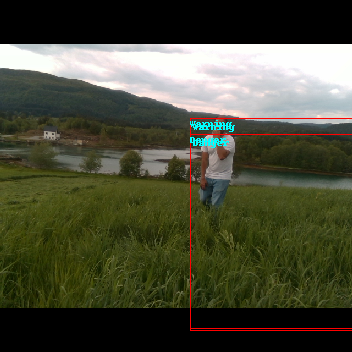

In [243]:
from PIL import ImageDraw

arr = b.cpu().mul(255).permute(0,2,3,1).byte().numpy()
image = Image.fromarray(arr[example_ind])
print (image.size, image.mode)
pshape = imgs.shape

#overlay = Image.new("L", (pshape[3], pshape[2]), 0)
#draw = ImageDraw.Draw(overlay)
draw = ImageDraw.Draw(image)

rects = [get_rect(*p) for p in boxes[:8]]

for index,rect in enumerate(rects):
    draw.line([tuple(p) for p in rect], width=1, fill=255)
    draw.text((rect[0]), class_names[predictions[index]], fill=(0,255,255,0),stroke_width=3)


    
#img = Image.merge("RGB", (image,overlay,image))
image

In [24]:
# pick one image from the test set
img, img2 = dataset_test[2]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

NameError: name 'dataset_test' is not defined

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [ ]:
print(img2.keys())
print(img2['boxes'])
mshape = img2['masks'].shape
arr = np.zeros((mshape[1],mshape[2]),dtype=np.uint8)
for i in range(mshape[0]):
    print ("load")
    arr += img2['masks'][i].mul(255).byte().numpy()
print (arr, np.unique(arr), arr.shape, type(arr))
image = Image.fromarray(arr)
image

In [ ]:
def get_rect(x, y, width, height):
    rect = [(x, y), (x+width, y), (x+width, y+height), (x, y+height), (x, y)]
    #rect = [(0, 0), (width, height)]
    
    return tuple(rect)

In [ ]:
from PIL import ImageDraw
pshape = prediction[0]['masks'].shape
boxes = prediction[0]['boxes'].cpu().numpy()
print(prediction[0]['masks'].shape)

arr = np.zeros((pshape[2],pshape[3]),dtype=np.uint8)
for i in range(pshape[0]):
    arr += prediction[0]['masks'][i,0].mul(255).byte().cpu().numpy()
image = Image.fromarray(arr)


overlay = Image.new("L", (pshape[3], pshape[2]), 0)
draw = ImageDraw.Draw(overlay)
rects = [get_rect(*p) for p in boxes]

for rect in rects:
    draw.line([tuple(p) for p in rect], width=3, fill=500)


print(image.size)
print(overlay.size)

img = Image.merge("RGB", (image,overlay,image))
(image,overlay)
img